In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
import colormaps as cmaps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

os.chdir(r'D:\pku\UES\UrbanHeatIsland\Data\202501_allpixel')

In [ ]:
#merge GRs scenarios in each country
if 0 :
    df_all = pd.DataFrame()
    dfs = os.listdir('./GRs')
    for name in dfs:
        if name.endswith('.csv'):
            df = pd.read_csv('./GRs/'+name)
            df_all = pd.concat([df_all, df], ignore_index=True)
    df_all.to_csv('./GRs_all_merged.csv', index=False)
    df_all_simple = df_all[['ADM0_CODE','ADM0_NAME','ADM1_CODE','ADM1_NAME','ADM2_CODE','ADM2_NAME','low_cc','low_cc_change','medium_cc','medium_cc_change','high_cc','high_cc_change','.geo']]
    #remove duplicate
    df_all_simple.drop_duplicates(subset=['ADM2_CODE'], keep='first', inplace=True)
    geom = [shape(eval(i)) for i in df_all_simple['.geo']]
    df_all_simple = gpd.GeoDataFrame(df_all_simple,geometry=geom)
    df_all_simple['geometry'] = df_all_simple['geometry'].centroid
    df_all_simple.to_file(r'.\df_GRs_all_simple.geojson', driver="GeoJSON")

C:\Users\admin\AppData\Local\Temp\ipykernel_28468\2862354876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_simple.drop_duplicates(subset=['ADM2_CODE'], keep='first', inplace=True)
c:\Users\admin\.conda\envs\nicenv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [2]:
#check null roof simulations
df_all_simple = gpd.read_file(r'.\df_GRs_all_simple.geojson')
df_all_simple.isnull().sum()

ADM0_CODE              0
ADM0_NAME              0
ADM1_CODE              0
ADM1_NAME              0
ADM2_CODE              0
ADM2_NAME              0
low_cc              2373
low_cc_change       2373
medium_cc           2373
medium_cc_change    2373
high_cc             2373
high_cc_change      2373
.geo                   0
geometry               0
dtype: int64

In [3]:
#connect to model4 pars
df_model4 = pd.read_csv('./pars_quality_final_ava_model4_allpixel_watermask0_vif.csv')
df_scenarios = pd.merge(df_all_simple, 
                        df_model4[['ADM2CODE', 'model', 'coefs', '2.5 %', '97.5 %', 'estimate','par_p_value', 'rmse', 'r2', 'p_value']],
                        left_on='ADM2_CODE', right_on='ADM2CODE' ,how='right')
#remove null scenarios
df_scenarios_ava = df_scenarios.dropna(subset=['low_cc'], inplace=False)
df_scenarios_ava.columns

Index(['ADM0_CODE', 'ADM0_NAME', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE',
       'ADM2_NAME', 'low_cc', 'low_cc_change', 'medium_cc', 'medium_cc_change',
       'high_cc', 'high_cc_change', '.geo', 'geometry', 'ADM2CODE', 'model',
       'coefs', '2.5 %', '97.5 %', 'estimate', 'par_p_value', 'rmse', 'r2',
       'p_value'],
      dtype='object')

In [4]:
#cooling effects
df_cooling = pd.DataFrame()
df_cooling['ADM2_CODE'] = df_scenarios_ava['ADM2_CODE']
df_cooling['model'] = df_scenarios_ava['model']
df_cooling['estimate'] = df_scenarios_ava['estimate']
df_cooling['low_cc_cooling'] = df_scenarios_ava['low_cc_change']*df_scenarios_ava['estimate']
df_cooling['mid_cc_cooling'] = df_scenarios_ava['medium_cc_change']*df_scenarios_ava['estimate']
df_cooling['hig_cc_cooling'] = df_scenarios_ava['high_cc_change']*df_scenarios_ava['estimate']

df_cooling['uncertainty_ratio'] = 0.5 * (df_scenarios_ava['2.5 %'] - df_scenarios_ava['97.5 %']) / df_scenarios_ava['estimate']

# df_cooling['low_cc_uncertainty'] = df_scenarios_ava['low_cc_change']*(df_scenarios_ava['2.5 %'] - df_scenarios_ava['97.5 %'])
# df_cooling['mid_cc_uncertainty'] = df_scenarios_ava['medium_cc_change']*(df_scenarios_ava['2.5 %'] - df_scenarios_ava['97.5 %'])
# df_cooling['hig_cc_uncertainty'] = df_scenarios_ava['high_cc_change']*(df_scenarios_ava['2.5 %'] - df_scenarios_ava['97.5 %'])

In [5]:
df_cooling = gpd.GeoDataFrame(df_cooling,geometry=df_scenarios_ava['geometry'])

In [ ]:
#edit urban props
'''
1 Taiwan was calculated separately
2 some cities 65060, 15524, 3994, 14263,3887,10168,33375
were found with zero roof area but tiny cooling effect due to
the cooling simulation was calculated at 250 resolution,
that some of the pixels were overlapped with the smod urban layer,
but the calculation of roof area is at 2.5 resolution,
lead to no overlapped roofs, here we keep the cooling effect
'''
if 0:
    df_urban_stat = pd.read_csv('./Urban_stat_lst_vc_rural_urban.csv')
    #drop duplicate
    df_urban_stat = df_urban_stat.drop_duplicates(subset=['ADM2_CODE'],keep='first')
    #merge cold and polar
    # df_urban_stat.loc[df_urban_stat['koppen_climate_remap'].isin([4,5]), 'koppen_climate_remap'] = 4

    #lst bins
    day_temp_bins = [-np.inf,28,32,36,np.inf]
    night_temp_bins = [-np.inf,22,24,28,np.inf]
    df_urban_stat['LST_day_mean_bins'] = pd.cut(df_urban_stat['LST_urban_day_mean']-273.15,bins=day_temp_bins,labels=['<28','28~32','32~36','>36'])
    df_urban_stat['LST_night_mean_bins'] = pd.cut(df_urban_stat['LST_urban_night_mean']-273.15,bins=night_temp_bins,labels=['<22','22~24','24~28','>28'])

    #new roof area 
    df_roofarea_glob = pd.read_csv('./Urban_stat_lst_roofarea_global_exchina.csv')
    df_roofarea_chn = pd.read_csv('./Urban_stat_lst_roofarea_chn.csv')
    df_roofarea_chn_taiwan = pd.read_csv('./Urban_stat_lst_roofarea_chn_taiwan.csv')
    df_roofarea_glob2 = df_roofarea_glob.loc[df_roofarea_glob['ADM0_NAME']!='China',:]
    df_roofarea_glob2 = pd.concat([df_roofarea_glob2,df_roofarea_chn,df_roofarea_chn_taiwan])
    df_urban_stat2 = pd.merge(df_urban_stat, df_roofarea_glob2[['roof_area','ADM2_CODE']], on=['ADM2_CODE'], how='left')
    df_urban_stat2.to_csv('./Urban_stat_lst_vc_rural_urban_clean.csv', index=False)

In [6]:
# assign continent manually in excel
df_urban_stat = pd.read_csv('./Urban_stat_lst_vc_rural_urban_clean.csv')
df_urban_stat.drop_duplicates(subset=['ADM2_CODE'],inplace=True)

# vc bins
vc_bins = [0,20,40,60,80,100]
df_urban_stat['vc_mean_bins'] = pd.cut(df_urban_stat['vc_mean'],bins=vc_bins,labels=['0~20','20~40','40~60','60~80','80~100'])

# roof area bins
roof_bins = [0,1e5,1e6,1e7,1e8,np.inf]
df_urban_stat['roof_area_bins'] = pd.cut(df_urban_stat['roof_area'],bins=roof_bins,labels=['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8'])

# roof area/urban area bins
df_urban_stat['roof_ratio'] = df_urban_stat['roof_area']/df_urban_stat['urban_area']

rr_bins = [0,0.2,0.4,0.6,0.8,1]
df_urban_stat['roof_ratio_bins'] = pd.cut(df_urban_stat['roof_ratio'],bins=rr_bins,labels=['0~20','20~40','40~60','60~80','80~100'])

#only present results with valid properties for consistency
df_cooling_stat = pd.merge(df_cooling,df_urban_stat[['vc_mean','vc_mean_bins',
                                                     'urban_area','roof_area','roof_area_bins','roof_ratio','roof_ratio_bins',
                                                     'population_count','Continent',
                                                     'LST_urban_day_mean','LST_urban_night_mean','LST_day_mean_bins','LST_night_mean_bins',
                                                     'LST_rural_day_mean','LST_rural_night_mean',
                                                     'ADM2_CODE','ADM0_CODE']],on=['ADM2_CODE'],how='left')

#remove several outliers (roof_area = inf or >1, because of the projection or layer distortion)
df_cooling_stat = df_cooling_stat.loc[(~np.isinf(df_cooling_stat['roof_ratio'])) & (df_cooling_stat['roof_ratio'] < 1),:]
#drop na and inf 
df_cooling_stat = df_cooling_stat.dropna()

In [7]:
#statistics

#1 avaliable cities
print('all',df_cooling_stat['ADM2_CODE'].unique().shape[0])
print('day',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day','ADM2_CODE'].count())
print('night',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night','ADM2_CODE'].count())
df_cooling_count = df_cooling_stat.groupby('ADM2_CODE').count().reset_index()
df_cooling_count_2_code = df_cooling_count.loc[df_cooling_count['model'] == 2,'ADM2_CODE']
print('paired',len(df_cooling_count_2_code))
print('------')
#2 global cooling potential
print('day cooling potential\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].mean().round(2))
print('day cooling potential sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].std().round(2))
print('night cooling potential\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].mean().round(2))
print('night cooling potential sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].std().round(2))
print('------')
#3 cooling uncertainties
print('day cooling uncertainty\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['uncertainty_ratio']].mean().round(2))
print('day cooling uncertainty sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['uncertainty_ratio']].std().round(2))
print('night cooling uncertainty\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['uncertainty_ratio']].mean().round(2))
print('night cooling uncertainty sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['uncertainty_ratio']].std().round(2))

all 4835
day 3913
night 1687
paired 765
------
day cooling potential
 low_cc_cooling   -0.57
mid_cc_cooling   -1.12
hig_cc_cooling   -1.58
dtype: float64
day cooling potential sd
 low_cc_cooling    0.47
mid_cc_cooling    0.92
hig_cc_cooling    1.31
dtype: float64
night cooling potential
 low_cc_cooling   -0.14
mid_cc_cooling   -0.27
hig_cc_cooling   -0.39
dtype: float64
night cooling potential sd
 low_cc_cooling    0.14
mid_cc_cooling    0.27
hig_cc_cooling    0.38
dtype: float64
------
day cooling uncertainty
 uncertainty_ratio    0.22
dtype: float64
day cooling uncertainty sd
 uncertainty_ratio    0.17
dtype: float64
night cooling uncertainty
 uncertainty_ratio    0.29
dtype: float64
night cooling uncertainty sd
 uncertainty_ratio    0.19
dtype: float64


In [8]:
# bins = [-np.inf, -4, -2, -1, -0.5, 0]
# labels = ['>4.00','2.00~4.00','1.00~2.00','0.50~1.00','0.00~0.50']

bins = [-np.inf, -2, -1, -0.5, -0.25, 0]
labels = ['>2.00','1.00~2.00','0.50~1.00','0.25~0.50','0.00~0.25']
df_cooling_stat['low_cc_cooling_class'] = pd.cut(df_cooling_stat['low_cc_cooling'], bins=bins, labels=labels)
df_cooling_stat['mid_cc_cooling_class'] = pd.cut(df_cooling_stat['mid_cc_cooling'], bins=bins, labels=labels)
df_cooling_stat['hig_cc_cooling_class'] = pd.cut(df_cooling_stat['hig_cc_cooling'], bins=bins, labels=labels)
# df_cooling['low_cc_uncertainty_class'] = pd.cut(df_cooling['low_cc_uncertainty'], bins=bins, labels=labels)
# df_cooling['mid_cc_uncertainty_class'] = pd.cut(df_cooling['mid_cc_uncertainty'], bins=bins, labels=labels)
# df_cooling['hig_cc_uncertainty_class'] = pd.cut(df_cooling['hig_cc_uncertainty'], bins=bins, labels=labels)

In [9]:
df_cooling_stat.columns

Index(['ADM2_CODE', 'model', 'estimate', 'low_cc_cooling', 'mid_cc_cooling',
       'hig_cc_cooling', 'uncertainty_ratio', 'geometry', 'vc_mean',
       'vc_mean_bins', 'urban_area', 'roof_area', 'roof_area_bins',
       'roof_ratio', 'roof_ratio_bins', 'population_count', 'Continent',
       'LST_urban_day_mean', 'LST_urban_night_mean', 'LST_day_mean_bins',
       'LST_night_mean_bins', 'LST_rural_day_mean', 'LST_rural_night_mean',
       'ADM0_CODE', 'low_cc_cooling_class', 'mid_cc_cooling_class',
       'hig_cc_cooling_class'],
      dtype='object')

In [10]:
#uncertainty ratio
bins = [0,0.2,0.4,0.6,np.inf]
labels = ['0.00~0.20','0.20~0.40','0.40~0.60','>0.60']
df_cooling_stat['uncertainty_ratio_class'] = pd.cut(df_cooling_stat['uncertainty_ratio'], bins=bins, labels=labels)

In [11]:
#efficiency
bins = [-np.inf,-0.2,-0.15,-0.1,-0.05,0]
labels = ['>0.20','0.15~0.20','0.10~0.15','0.05~0.10','0.00~0.05']
df_cooling_stat['efficiency_class'] = pd.cut(df_cooling_stat['estimate'], bins=bins, labels=labels)

In [12]:
df_cooling_stat.loc[df_cooling_stat['model'] == "model4_day",'uncertainty_ratio_class'].describe()

count          3913
unique            4
top       0.00~0.20
freq           2259
Name: uncertainty_ratio_class, dtype: object

In [13]:
2259/3913

0.5773064145157168

In [14]:
df_cooling_stat.loc[df_cooling_stat['model'] == "model4_night",'uncertainty_ratio_class'].describe()

count          1687
unique            4
top       0.00~0.20
freq            679
Name: uncertainty_ratio_class, dtype: object

In [114]:
679/1687

0.4024896265560166

In [15]:
df_cooling_stat['uncertainty_ratio'].describe()

count    5600.000000
mean        0.238420
std         0.177739
min         0.004851
25%         0.099055
50%         0.188327
75%         0.338276
max         0.760091
Name: uncertainty_ratio, dtype: float64

In [16]:
# count cities in each class
def count_cities_in_class(df, column=['low_cc_cooling_class', 'mid_cc_cooling_class', 'hig_cc_cooling_class']):

    column_value_counts = {}

    for col in column:
        column_value_counts[col] = df[col].value_counts().sort_index()

    df_column_value_counts = pd.DataFrame(column_value_counts)
    return df_column_value_counts

def plot_bar_with_labels(ax, data, column, colors, ylabel='Number of cities',xlabel= '',ftsize=2, ylabel_loc = 'bottom',ylabel_pad=0.5,height_str = ' <1'):
    bars = ax.bar(data.index, data[column], color=colors,edgecolor='dimgray',linewidth=0.2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for bar in bars:
        height = bar.get_height()
        if height < 1:
            height_str = height_str
        else:
            height_str = ' '+str(int(height))
        ax.text(bar.get_x() + bar.get_width() / 2, height, height_str,
                ha='center', va='bottom', rotation=90, fontsize=ftsize)
    
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.set_ylabel(ylabel, fontsize=ftsize,labelpad=ylabel_pad, loc=ylabel_loc)
    ax.set_xlabel(xlabel, fontsize=ftsize,labelpad=ylabel_pad)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('none')

In [17]:
df_cooling_day = df_cooling_stat[df_cooling_stat['model'] == 'model4_day']
df_cooling_night = df_cooling_stat[df_cooling_stat['model'] == 'model4_night']
df_cooling_day_stat = count_cities_in_class(df_cooling_day).iloc[::-1]
df_cooling_night_stat = count_cities_in_class(df_cooling_night).iloc[::-1]
df_cooling_day_stat_uncertainty = count_cities_in_class(df_cooling_day, column=['uncertainty_ratio_class'])
df_cooling_night_stat_uncertainty = count_cities_in_class(df_cooling_night, column=['uncertainty_ratio_class'])
df_cooling_day_stat_efficiency = count_cities_in_class(df_cooling_day, column=['efficiency_class'])
df_cooling_night_stat_efficiency = count_cities_in_class(df_cooling_night, column=['efficiency_class'])


In [18]:
#influence on suhi
df_cooling_day.loc[:,'Day_suhi'] = df_cooling_day.loc[:,'LST_urban_day_mean'] - df_cooling_day.loc[:,'LST_rural_day_mean']
df_cooling_night.loc[:,'Night_suhi'] = df_cooling_night.loc[:,'LST_urban_night_mean'] - df_cooling_night.loc[:,'LST_rural_night_mean']

df_cooling_day.loc[:,'low_suhi_change'] = -df_cooling_day.loc[:,'low_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_day.loc[:,'mid_suhi_change'] = -df_cooling_day.loc[:,'mid_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_day.loc[:,'hig_suhi_change'] = -df_cooling_day.loc[:,'hig_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_night.loc[:,'low_suhi_change'] = -df_cooling_night.loc[:,'low_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']
df_cooling_night.loc[:,'mid_suhi_change'] = -df_cooling_night.loc[:,'mid_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']
df_cooling_night.loc[:,'hig_suhi_change'] = -df_cooling_night.loc[:,'hig_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']

#filter SUHII >1 
df_cooling_day.loc[df_cooling_day.loc[:,'Day_suhi']<1,['low_suhi_change','mid_suhi_change','hig_suhi_change']] = np.nan
df_cooling_night.loc[df_cooling_night.loc[:,'Night_suhi']<1,['low_suhi_change','mid_suhi_change','hig_suhi_change']] = np.nan

#into bins
bins = [0,0.2,0.4,0.6,0.8,np.inf]
labels = ['0.00~0.20','0.20~0.40','0.40~0.60','0.60~0.80','>0.80']
df_cooling_day.loc[:,'low_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'low_suhi_change'], bins=bins, labels=labels)
df_cooling_day.loc[:,'mid_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'mid_suhi_change'], bins=bins, labels=labels)
df_cooling_day.loc[:,'hig_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'hig_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'low_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'low_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'mid_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'mid_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'hig_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'hig_suhi_change'], bins=bins, labels=labels)

c:\Users\admin\.conda\envs\nicenv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\admin\.conda\envs\nicenv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\admin\.conda\envs\nicenv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [19]:
print("day suhi change",df_cooling_day.loc[:,['low_suhi_change','mid_suhi_change','hig_suhi_change']].describe())
print("night suhi change",df_cooling_night.loc[:,['low_suhi_change','mid_suhi_change','hig_suhi_change']].describe())

day suhi change        low_suhi_change  mid_suhi_change  hig_suhi_change
count      3340.000000      3340.000000      3340.000000
mean          0.161280         0.316472         0.449030
std           0.177763         0.350108         0.503245
min           0.000425         0.000850         0.001275
25%           0.057925         0.115078         0.165410
50%           0.113523         0.221820         0.316096
75%           0.200900         0.394595         0.557831
max           2.453597         4.890689         7.036469
night suhi change        low_suhi_change  mid_suhi_change  hig_suhi_change
count      1053.000000      1053.000000      1053.000000
mean          0.064118         0.126422         0.181721
std           0.061912         0.121324         0.171729
min           0.000441         0.000882         0.001323
25%           0.019914         0.039380         0.057293
50%           0.046049         0.090867         0.130152
75%           0.087343         0.171101         0.2494

In [20]:
df_shui_change_day_stat = count_cities_in_class(df_cooling_day, column=['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class'])
df_suhi_change_night_stat = count_cities_in_class(df_cooling_night, column=['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class'])

In [18]:
df_cooling_day['low_cc_cooling_class'].unique()

['0.00~0.25', '0.25~0.50', '0.50~1.00', '1.00~2.00', '>2.00']
Categories (5, object): ['>2.00' < '1.00~2.00' < '0.50~1.00' < '0.25~0.50' < '0.00~0.25']

In [19]:
print('cities without urban stat',len(df_cooling),len(df_cooling_stat))

cities without urban stat 5638 5600


In [21]:
#color map and base map
cmp1 = plt.get_cmap('YlGnBu_r') #YlGnBu_r winter
colors1 = cmp1(np.linspace(0, 1, 7))[1:6]
cmp1 = mpl.colors.ListedColormap(colors1)

cmp2 = plt.get_cmap('Set3')
colors2 = cmp2(np.linspace(0, 1, 12))[0:4]
cmp2 = mpl.colors.ListedColormap(colors2)

cmp3 = plt.get_cmap('summer').reversed()
colors3 = cmp3(np.linspace(0, 1, 5))[0:5]
cmp3 = mpl.colors.ListedColormap(colors3)

# cmp2 = plt.get_cmap('BuGn')
# cmp2 = cmp2(np.linspace(0,1,256))
# cmp2 = ListedColormap(cmp2[50:256])

# custom_color1 = ['#64f38c','#f79d00']
# colors1 = np.linspace(mpl.colors.hex2color(custom_color1[0]),
#                     mpl.colors.hex2color(custom_color1[1]), 5)  # Interpolate between the two colors, 256 steps
# cmp1 = mpl.colors.ListedColormap(colors1)

# cmp1 = cmaps.ylgnbu[2:7].reversed()
# colors1 = cmp1(np.linspace(0, 1, 5))
# cmp1 = mpl.colors.ListedColormap(colors1)

# df_world = gpd.read_file(r"D:\pku\UES\Maps\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp")
# df_world = df_world[df_world['SOVEREIGNT'] != 'Antarctica']

In [109]:
#figure 1 daytime cooling effects
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_cc_cooling_class','mid_cc_cooling_class','hig_cc_cooling_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_day.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_night.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=['0.00–0.25', '0.25–0.50','0.50–1.00','1.00–2.00','>2.00'], fontsize=12)
#set title
cbar.set_label('Cooling potential (°C)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig('./Figs_rev1/fig2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig2.pdf', dpi=300, bbox_inches='tight')
plt.close()

In [24]:
#figure s1 daytime cooling effects uncertainty ratio
#plot
fig,axs = plt.subplots(1,2,figsize=(9,3),dpi=300,subplot_kw={'projection': ccrs.Robinson()})

axs[0].set_global()
axs[0].add_feature(cfeature.LAND, facecolor="silver")
axs[0].set_extent([-180, 180, -60, 90])
cax = df_cooling_day.plot(column='uncertainty_ratio_class', ax=axs[0], cmap=cmp2, legend=False,
             edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
             legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
inset_ax = inset_axes(axs[0], width="20%", height="20%", 
                      bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=axs[0].transAxes)
plot_bar_with_labels(inset_ax, df_cooling_day_stat_uncertainty, 'uncertainty_ratio_class', colors2,xlabel='',ftsize=7)

axs[1].set_global()
axs[1].add_feature(cfeature.LAND, facecolor="silver")
axs[1].set_extent([-180, 180, -60, 90])
cax = df_cooling_night.plot(column='uncertainty_ratio_class', ax=axs[1], cmap=cmp2, legend=False,
             edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
             legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
inset_ax = inset_axes(axs[1], width="20%", height="20%", 
                      bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=axs[1].transAxes)
plot_bar_with_labels(inset_ax, df_cooling_night_stat_uncertainty, 'uncertainty_ratio_class', colors2,xlabel='',ftsize=7)


axs[0].set_title('Day', loc='center', fontsize=12)
axs[1].set_title('Night', loc='center', fontsize=12)

norm = mpl.colors.Normalize(vmin=0, 
                            vmax=0.8)
sm = plt.cm.ScalarMappable(cmap=cmp2, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[0.1,0.3,0.5,0.7],labels=['0–20','20–40','40–60','>60'], fontsize=12)
#set title
cbar.set_label('Cooling potential uncertainty (%)',fontsize=12)

#add labels
labels = ['a', 'b']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('./Figs_rev1/figs1.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/figs1.pdf', dpi=300, bbox_inches='tight')
plt.close()

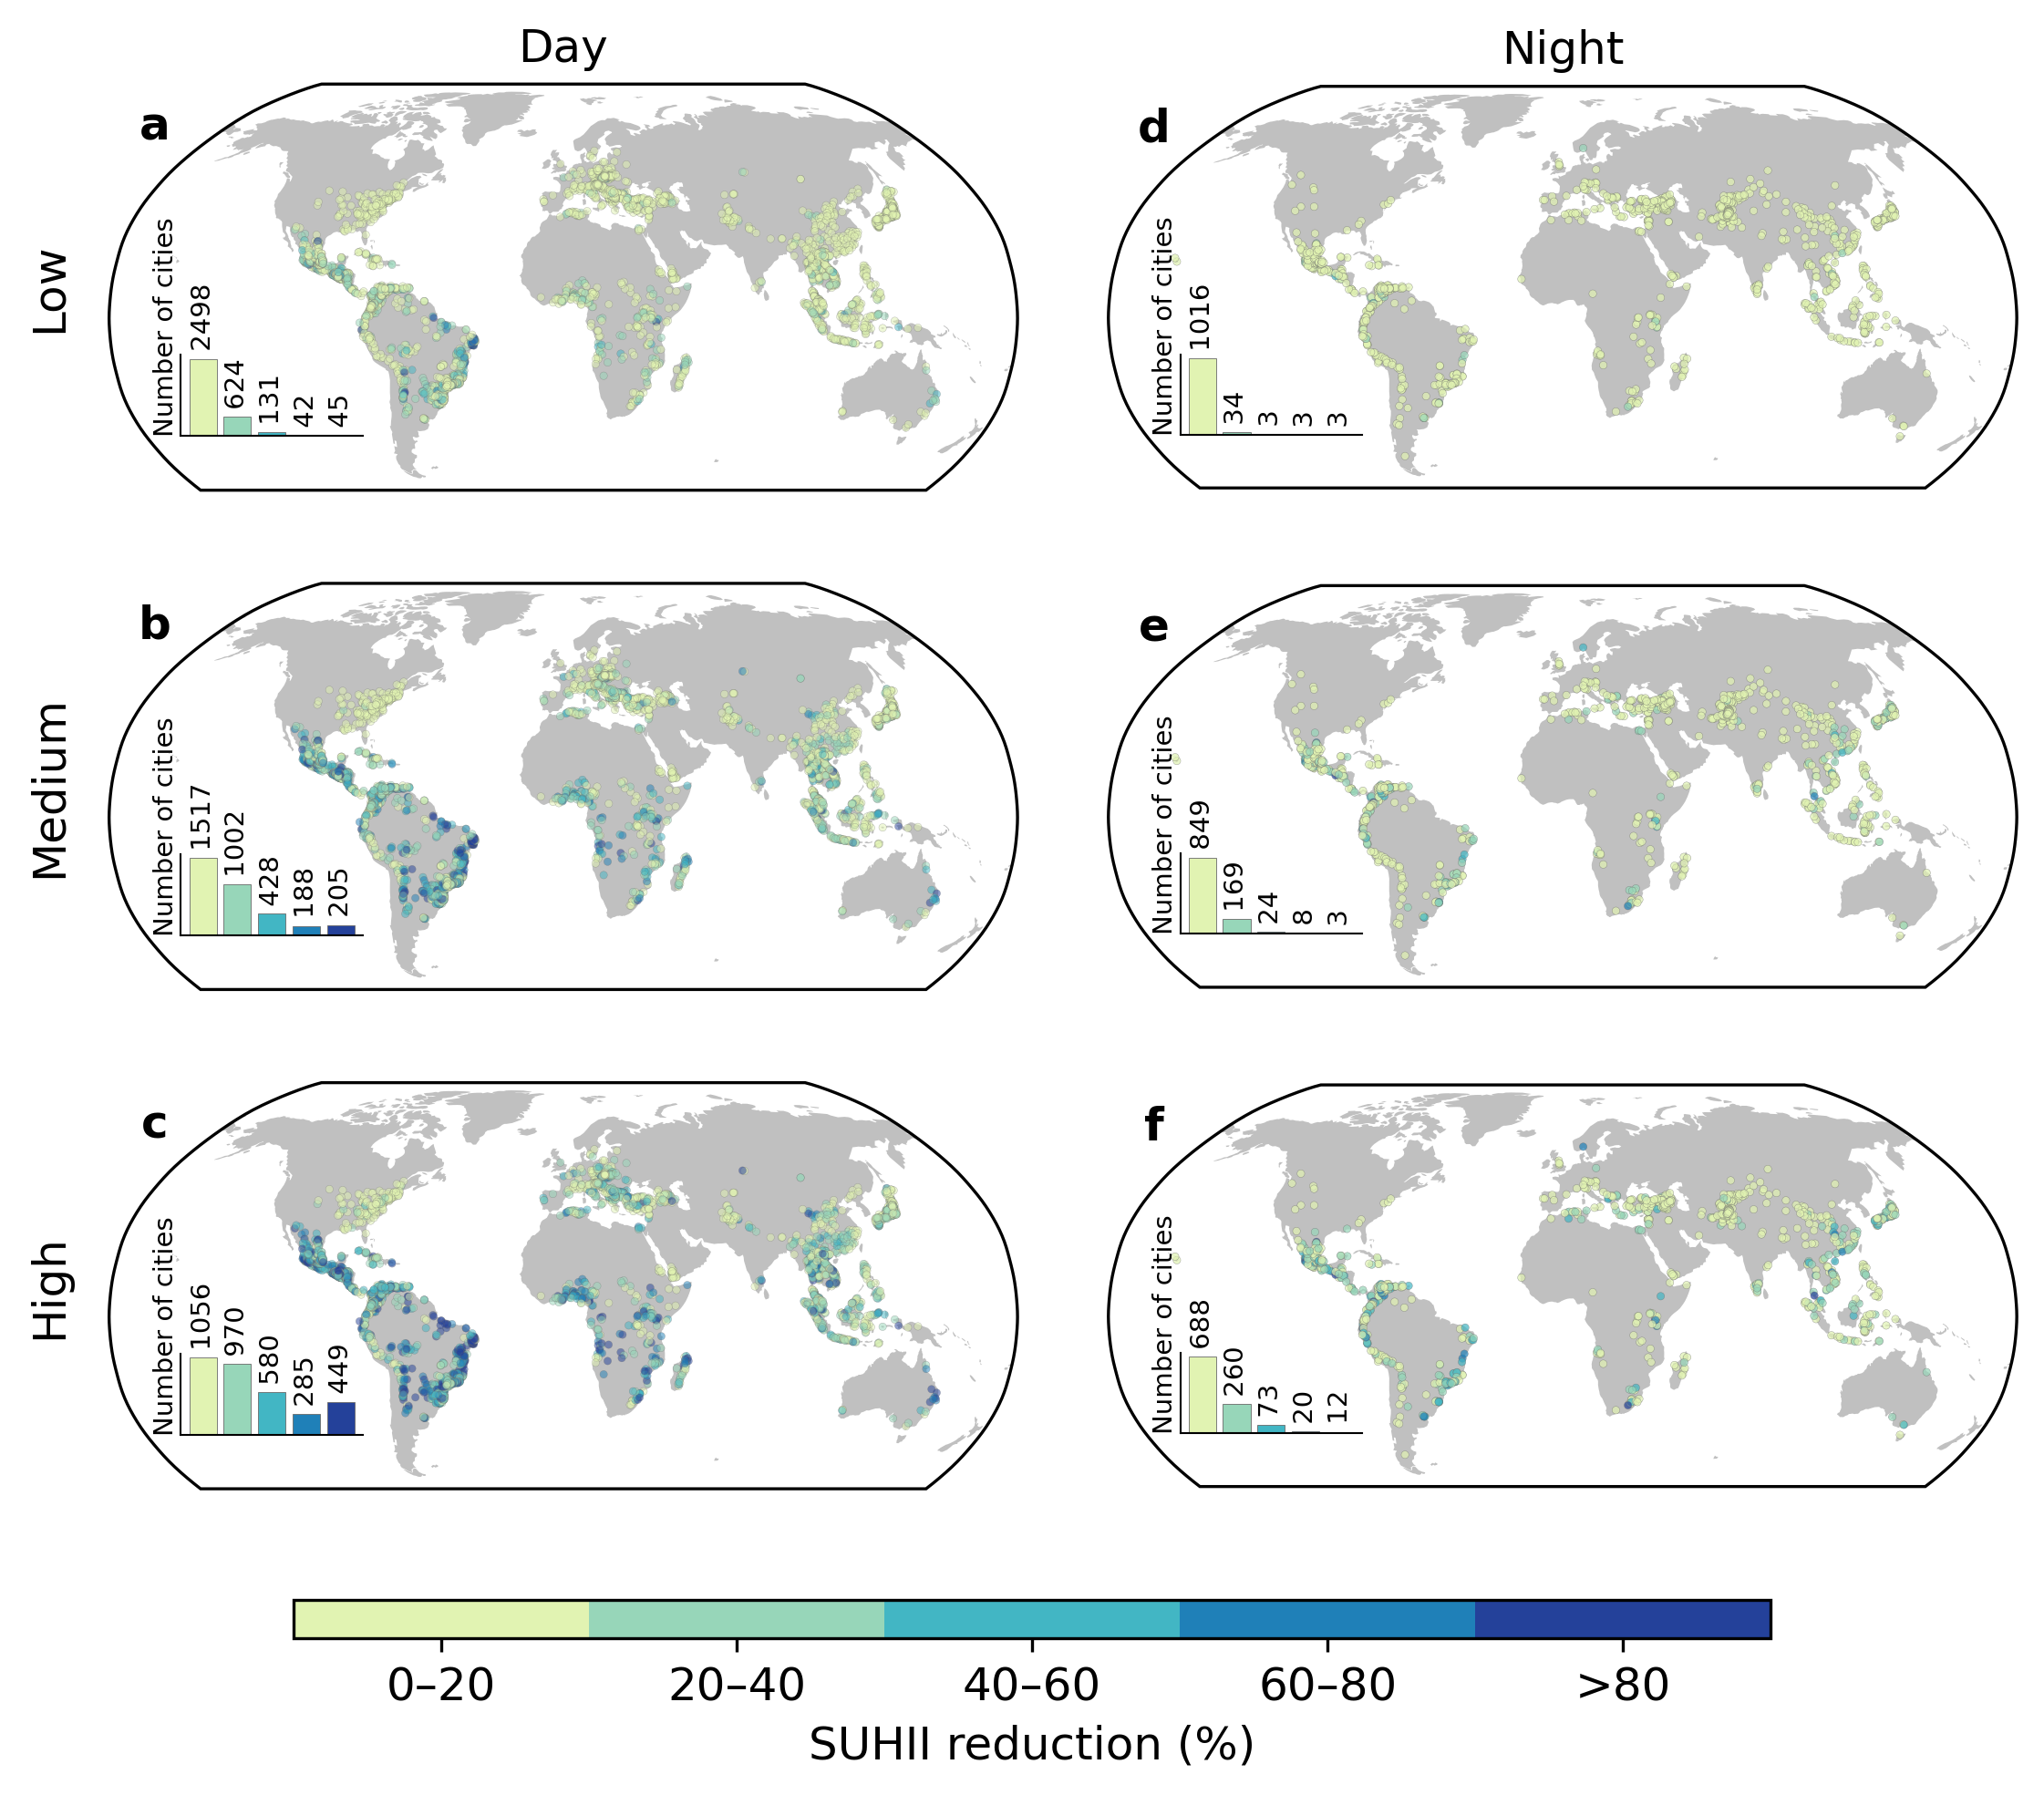

In [116]:
#figure changes on shui
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_day.plot(column=col_name, ax=ax_i, cmap=cmp1.reversed(), legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_shui_change_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_night.plot(column=col_name, ax=ax_i, cmap=cmp1.reversed(), legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_suhi_change_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=["0–20","20–40","40–60","60–80",">80"], fontsize=12)
#set title
cbar.set_label('SUHII reduction (%)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig('./Figs_rev1/fig_suhi.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig_suhi.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [28]:
#influence on suhi
df_cooling_stat.columns

Index(['ADM2_CODE', 'model', 'low_cc_cooling', 'mid_cc_cooling',
       'hig_cc_cooling', 'uncertainty_ratio', 'geometry', 'vc_mean',
       'vc_mean_bins', 'urban_area', 'roof_area', 'roof_area_bins',
       'roof_ratio', 'roof_ratio_bins', 'population_count', 'Continent',
       'LST_urban_day_mean', 'LST_urban_night_mean', 'LST_day_mean_bins',
       'LST_night_mean_bins', 'LST_rural_day_mean', 'LST_rural_night_mean',
       'ADM0_CODE', 'low_cc_cooling_class', 'mid_cc_cooling_class',
       'hig_cc_cooling_class', 'uncertainty_ratio_class'],
      dtype='object')

In [117]:
#figure 2 statistics
df_cooling_stat['low_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['low_cc_cooling']
df_cooling_stat['mid_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['mid_cc_cooling']
df_cooling_stat['hig_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['hig_cc_cooling']

In [118]:
df_cooling_stat_continent_longer = df_cooling_stat[['ADM2_CODE','model','Continent','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','Continent','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_continent_longer['effects'] = abs(df_cooling_stat_continent_longer['effects'])

df_cooling_stat_day_background_longer = df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',
                                                            ['ADM2_CODE','model','LST_day_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','LST_day_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_day_background_longer['effects'] = abs(df_cooling_stat_day_background_longer['effects'])
df_cooling_stat_night_background_longer = df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',
                                                              ['ADM2_CODE','model','LST_night_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','LST_night_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_night_background_longer['effects'] = abs(df_cooling_stat_night_background_longer['effects'])

df_cooling_stat_vc_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','vc_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','vc_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_roofarea_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','roof_area_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','roof_area_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_rr_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','roof_ratio_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','roof_ratio_bins','model'],var_name='cooling_type',value_name='effects')
#abs
df_cooling_stat_vc_longer['effects'] = abs(df_cooling_stat_vc_longer['effects'])
df_cooling_stat_roofarea_longer['effects'] = abs(df_cooling_stat_roofarea_longer['effects'])
df_cooling_stat_rr_longer['effects'] = abs(df_cooling_stat_rr_longer['effects'])

In [119]:
df_cooling_stat_continent_pop_longer = df_cooling_stat[['ADM2_CODE','model','Continent','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','Continent','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_continent_pop_longer['effects'] = abs(df_cooling_stat_continent_pop_longer['effects'])*(1e-5)

df_cooling_stat_day_background_pop_longer = df_cooling_stat[['ADM2_CODE','model','LST_day_mean_bins','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','LST_day_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_day_background_pop_longer['effects'] = abs(df_cooling_stat_day_background_pop_longer['effects'])*(1e-5)
df_cooling_stat_night_background_pop_longer = df_cooling_stat[['ADM2_CODE','model','LST_night_mean_bins','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','LST_night_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_night_background_pop_longer['effects'] = abs(df_cooling_stat_night_background_pop_longer['effects'])*(1e-5)

In [120]:
#set colors
edge_colors = plt.get_cmap('BuGn')
edge_colors = edge_colors(np.linspace(0, 1, 4))
edge_colors = [edge_colors[i] for i in [1,2,3]]
edge_colors = plt.get_cmap('Set2')
edge_colors = edge_colors(np.linspace(0, 1, 8))[0:3]
white_colors = ['white','white','white']

continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
climate_order = [1,2,3,4]
day_bg_order = ['<28','28~32','32~36','>36']
night_bg_order = ['<22','22~24','24~28','>28']
vc_order = ['0~20','20~40','40~60','60~80','80~100']
roof_area_order = ['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8']
rr_order = ['0.0~0.2','0.2~0.4','0.4~0.6','0.6~0.8','0.8~1.0']

In [121]:
#LST    
print('LST-day',df_cooling_stat_day_background_longer[df_cooling_stat_day_background_longer['model'] == 'model4_day'].groupby(['LST_day_mean_bins','cooling_type']).count())
print('LST-night',df_cooling_stat_night_background_longer[df_cooling_stat_night_background_longer['model'] == 'model4_night'].groupby(['LST_night_mean_bins','cooling_type']).count())

print('vc_bins_stat-day',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_day'].groupby(['vc_mean_bins','cooling_type']).count())
print('vc_bins_stat-night',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_night'].groupby(['vc_mean_bins','cooling_type']).count())

print('roof_ratio_bins_stat-day',df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_day'].groupby(['roof_ratio_bins','cooling_type']).count())
print('roof_ratio_bins_stat-night',df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_night'].groupby(['roof_ratio_bins','cooling_type']).count())

LST-day                                   ADM2_CODE  model  effects
LST_day_mean_bins cooling_type                             
28~32             hig_cc_cooling        947    947      947
                  low_cc_cooling        947    947      947
                  mid_cc_cooling        947    947      947
32~36             hig_cc_cooling       1483   1483     1483
                  low_cc_cooling       1483   1483     1483
                  mid_cc_cooling       1483   1483     1483
<28               hig_cc_cooling        338    338      338
                  low_cc_cooling        338    338      338
                  mid_cc_cooling        338    338      338
>36               hig_cc_cooling       1145   1145     1145
                  low_cc_cooling       1145   1145     1145
                  mid_cc_cooling       1145   1145     1145
LST-night                                     ADM2_CODE  model  effects
LST_night_mean_bins cooling_type                             
22~24             

C:\Users\admin\AppData\Local\Temp\ipykernel_39896\3218855224.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print('vc_bins_stat-day',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_day'].groupby(['vc_mean_bins','cooling_type']).count())
C:\Users\admin\AppData\Local\Temp\ipykernel_39896\3218855224.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print('vc_bins_stat-night',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_night'].groupby(['vc_mean_bins','cooling_type']).count())
C:\Users\admin\AppData\Local\Temp\ipykernel_39896\3218855224.py:8: FutureWarning

In [85]:
df_cooling_stat_rr_longer.loc[(df_cooling_stat_rr_longer['model'] == 'model4_day') & (df_cooling_stat_rr_longer['roof_ratio_bins'] == '80~100'),:]

ADM2_CODE roof_ratio_bins       model    cooling_type   effects
1315     13683.0          80~100  model4_day  low_cc_cooling  0.408199
1463     14283.0          80~100  model4_day  low_cc_cooling  1.250513
2402     20274.0          80~100  model4_day  low_cc_cooling  0.495145
6915     13683.0          80~100  model4_day  mid_cc_cooling  0.753278
7063     14283.0          80~100  model4_day  mid_cc_cooling  2.354413
8002     20274.0          80~100  model4_day  mid_cc_cooling  0.982593
12515    13683.0          80~100  model4_day  hig_cc_cooling  0.908841
12663    14283.0          80~100  model4_day  hig_cc_cooling  3.079764
13602    20274.0          80~100  model4_day  hig_cc_cooling  1.391660

C:\Users\admin\AppData\Local\Temp\ipykernel_39896\2100186324.py:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=df_cooling_stat_day_background_longer.loc[df_cooling_stat_day_background_longer['model'] == 'model4_day',:],
C:\Users\admin\AppData\Local\Temp\ipykernel_39896\2100186324.py:22: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(data=df_cooling_stat_day_background_longer.loc[df_cooling_stat_day_background_longer['model'] == 'model4_day',:],
C:\Users\admin\AppData\Local\Temp\ipykernel_39896\2100186324.py:26: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=df_cooling_stat_night_background_longer[df_cooling_stat_night_background_longer['model'] == 'model4_night'],
C:\Users\admin\AppData\Local\Temp\ipykerne

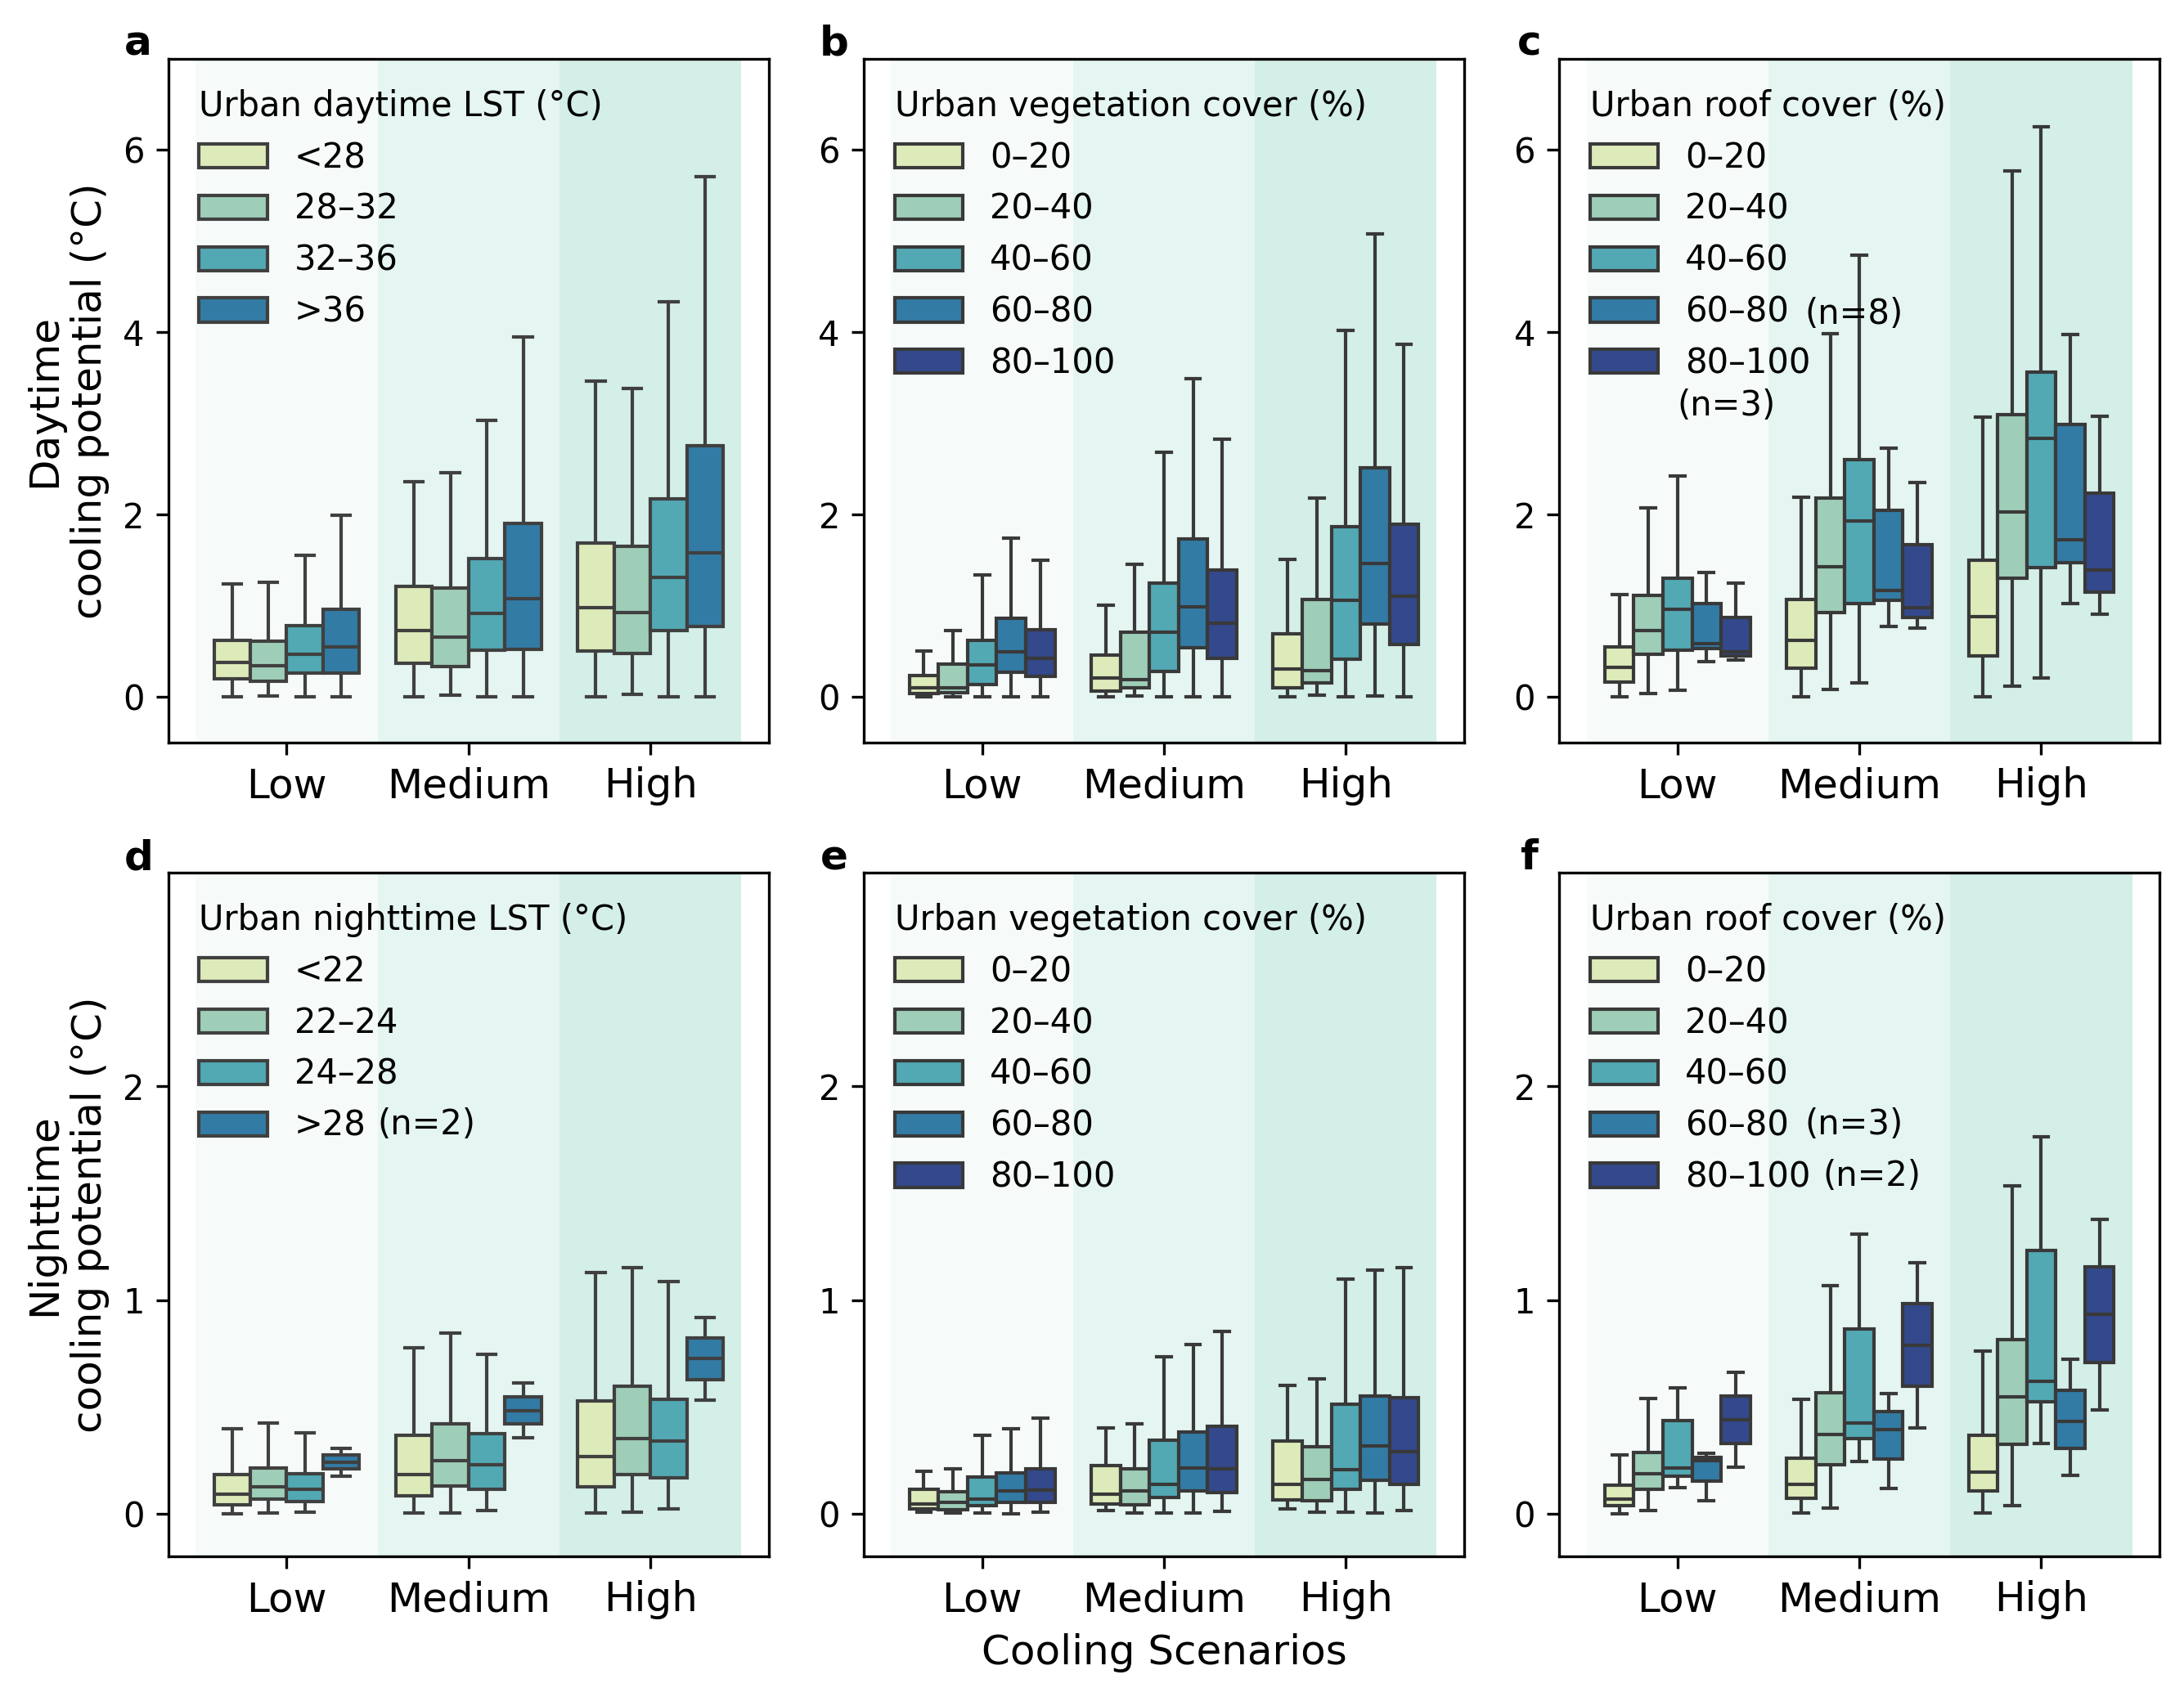

In [130]:
#figure 2 boxplot roof ratio group by bins

#set colors
# edge_colors = plt.get_cmap('GnBu')
# edge_colors = edge_colors(np.linspace(0, 1, 8))[0:5]
edge_colors = colors1[::-1]

bg_colors = plt.get_cmap('BuGn')
bg_colors = bg_colors(np.linspace(0, 1, 4))
bg_colors = [bg_colors[i] for i in [1,2,3]]

continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
climate_order = [1,2,3,4]
day_bg_order = ['<28','28~32','32~36','>36']
night_bg_order = ['<22','22~24','24~28','>28']
vc_order = ['0~20','20~40','40~60','60~80','80~100']
roof_area_order = ['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8']
rr_order = ['0~20','20~40','40~60','60~80','80~100']

fig,axs = plt.subplots(2,3,figsize=(9,7),dpi=300)

sns.boxplot(data=df_cooling_stat_day_background_longer.loc[df_cooling_stat_day_background_longer['model'] == 'model4_day',:],
            x='cooling_type', y='effects', hue='LST_day_mean_bins',
            hue_order=day_bg_order, palette=edge_colors, ax=axs[0,0], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_night_background_longer[df_cooling_stat_night_background_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='LST_night_mean_bins',
            hue_order=night_bg_order, palette=edge_colors, ax=axs[1,0], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_day'],
            x='cooling_type', y='effects', hue='vc_mean_bins',
            hue_order=vc_order, palette=edge_colors, ax=axs[0,1], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='vc_mean_bins',
            hue_order=vc_order, palette=edge_colors, ax=axs[1,1], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_day'],
            x='cooling_type', y='effects', hue='roof_ratio_bins',
            hue_order=rr_order, palette=edge_colors, ax=axs[0,2], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='roof_ratio_bins',
            hue_order=rr_order, palette=edge_colors, ax=axs[1,2], zorder=3, showfliers=False)

axs[0,1].sharey(axs[0,0])
axs[0,2].sharey(axs[0,0])

# axs[1,0].sharey(axs[0,0])
# axs[1,1].sharey(axs[0,1])
# axs[1,2].sharey(axs[0,2])

axs[1,1].sharey(axs[1,0])
axs[1,2].sharey(axs[1,0])
axs[1,0].set_ylim(-0.2,3)
axs[1,0].set_yticks([0,1,2])

axs[0,0].set_ylim(-0.5,7)

axs[0,0].set_yticks([0,2,4,6])
axs[0,1].set_yticks([0,2,4,6])
axs[0,2].set_yticks([0,2,4,6])

axs[0,0].set_ylabel('Daytime\ncooling potential (°C)',fontsize=12)
axs[1,0].set_ylabel('Nighttime\ncooling potential (°C)',fontsize=12)

axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[1,2].set_ylabel('')

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')
axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('Cooling Scenarios',fontsize=12)
axs[1,2].set_xlabel('')

for ax in axs.flat:
    ax.set_xticklabels(['Low','Medium','High'],fontsize=12)

# background hspan
for ax in axs.flat:
    ax.axvspan(-0.5, 0.5, facecolor=bg_colors[0], alpha=0.1, zorder=0)
    ax.axvspan(0.5, 1.5, facecolor=bg_colors[0], alpha=0.3, zorder=0)
    ax.axvspan(1.5, 2.5, facecolor=bg_colors[0], alpha=0.5, zorder=0)

#remove legend

# axs[0].spines['top'].set_visible(False)
# axs[0].spines['right'].set_visible(False)
# axs[1].spines['top'].set_visible(False)
# axs[1].spines['right'].set_visible(False)

for ax in axs.flat:
    ax.legend_.remove() if ax.legend_ else None

#add legend
legend_title_list = ['Urban nighttime LST (°C)','Urban vegetation cover (%)', 'Urban roof cover (%)']
for i in range(3):
    handles, labels = axs[1,i].get_legend_handles_labels()
    labels = [label.replace('~','–') for label in labels]
    axs[1,i].legend(handles, labels, loc='upper left', ncol=1, 
                    frameon=False,title=legend_title_list[i],title_fontsize=10,alignment='left')

legend_title_list = ['Urban daytime LST (°C)','Urban vegetation cover (%)', 'Urban roof cover (%)']
for i in range(3):
    handles, labels = axs[0,i].get_legend_handles_labels()
    labels = [label.replace('~','–') for label in labels]
    axs[0,i].legend(handles, labels, loc='upper left', ncol=1,frameon=False,
                    title=legend_title_list[i],title_fontsize=10,alignment='left')

#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.flat):
    ax.text(-0.05, 1.05, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

# annotate sample numbers for clarity
axs[1,0].text(0.5, 1.82, '(n=2)', 
            fontsize=10,va='center', ha='left')
axs[0,2].text(0.7, 4.2, '(n=8)', 
            fontsize=10,va='center', ha='left')
axs[0,2].text(0, 3.2, '(n=3)', 
            fontsize=10,va='center', ha='left')
axs[1,2].text(0.7, 1.82, '(n=3)', 
            fontsize=10,va='center', ha='left')
axs[1,2].text(0.8, 1.58, '(n=2)', 
            fontsize=10,va='center', ha='left')

plt.tight_layout()
plt.savefig('./Figs_rev1/fig3_v2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig3_v2.pdf', dpi=300, bbox_inches='tight')


In [131]:
#multiply by -1 for plot
df_cooling_stat_continent_longer_h = df_cooling_stat_continent_longer.copy()
df_cooling_stat_continent_longer_h.loc[df_cooling_stat_continent_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_continent_longer_h.loc[df_cooling_stat_continent_longer_h['model'] == 'model4_day','effects']*(-1)

df_cooling_stat_day_background_longer_h = df_cooling_stat_day_background_longer.copy()
df_cooling_stat_day_background_longer_h.loc[df_cooling_stat_day_background_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_day_background_longer_h.loc[df_cooling_stat_day_background_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_night_background_longer_h = df_cooling_stat_night_background_longer.copy()

df_cooling_stat_continent_pop_longer_h = df_cooling_stat_continent_pop_longer.copy()
df_cooling_stat_continent_pop_longer_h.loc[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_continent_pop_longer_h.loc[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_day_background_pop_longer_h = df_cooling_stat_day_background_pop_longer.copy()
df_cooling_stat_day_background_pop_longer_h.loc[df_cooling_stat_day_background_pop_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_day_background_pop_longer_h.loc[df_cooling_stat_day_background_pop_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_night_background_pop_longer_h = df_cooling_stat_night_background_pop_longer.copy()

In [132]:
def barplot_double(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

def barplot_double2(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=None,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=None,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

def barplot_double_city(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs, palette=palette,errorbar=None,orient = 'h',linewidth=0.8)
    print(bar.patches)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs, palette=edge_colors,errorbar=None,orient = 'h',linewidth=0.8)
    for bar, edge_color in zip(bar.patches, np.tile(edge_colors,(6,1))):
        bar.set_edgecolor(edge_color)
    return bar

def barplot_double_alpha(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8,'alpha':0},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8,'alpha':0},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

In [ ]:
# #check eu
# df_temp = df_cooling_stat.loc[df_cooling_stat['Continent'] == 'Europe',['ADM2_CODE','population_count']]
# df_temp.to_csv(r'D:\pku\UES\UrbanHeatIsland\Data\202501_allpixel\eu_check_0.csv')

In [133]:
#statistics
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day','population_count'].sum())
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night','population_count'].sum())

print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cooling_population', 'mid_cooling_population','hig_cooling_population']].describe())
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cooling_population', 'mid_cooling_population','hig_cooling_population']].describe())


474670897.58026826
276288664.25300944
       low_cooling_population  mid_cooling_population  hig_cooling_population
count            3.913000e+03            3.913000e+03            3.913000e+03
mean            -5.675190e+04           -1.121389e+05           -1.616070e+05
std              2.808054e+05            5.576716e+05            8.150402e+05
min             -8.662736e+06           -1.730310e+07           -2.579427e+07
25%             -1.778926e+04           -3.494183e+04           -5.066668e+04
50%             -2.345500e+03           -4.648959e+03           -6.619545e+03
75%             -2.812143e+02           -5.466005e+02           -7.787809e+02
max             -0.000000e+00           -0.000000e+00           -0.000000e+00
       low_cooling_population  mid_cooling_population  hig_cooling_population
count            1.687000e+03            1.687000e+03            1.687000e+03
mean            -3.005672e+04           -5.965744e+04           -8.680780e+04
std              1.745795e

In [36]:
#statistics 
df_cooling_stat_continent_longer.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                   mean           std   
Continent     model        cooling_type                                 
Africa        model4_day   hig_cc_cooling  70127.451467  62114.581965   
                           low_cc_cooling  70127.451467  62114.581965   
                           mid_cc_cooling  70127.451467  62114.581965   
              model4_night hig_cc_cooling  65939.295139  51897.787850   
                           low_cc_cooling  65939.295139  51897.787850   
                           mid_cc_cooling  65939.295139  51897.787850   
Asia          model4_day   hig_cc_cooling  34585.933884  21712.814298   
                           low_cc_cooling  34585.933884  21712.814298   
                           mid_cc_cooling  34585.933884  21712.814298   
              model4_night hig_cc_cooling  33900.405298  26518.417094   
                           low_cc_cooling  33900.405298  26518.417094   
                           mid_cc_cooling  33900.405298  26518.417094   
Europe        model4_day   hig_cc_cooling  19537.165192   9537.908014   
                           low_cc_cooling  19537.165192   9537.908014   
                           mid_cc_cooling  19537.165192   9537.908014   
              model4_night hig_cc_cooling  17365.408163  11387.348477   
                           low_cc_cooling  17365.408163  11387.348477   
                           mid_cc_cooling  17365.408163  11387.348477   
North America model4_day   hig_cc_cooling  27554.718121  16846.447948   
                           low_cc_cooling  27554.718121  16846.447948   
                           mid_cc_cooling  27554.718121  16846.447948   
              model4_night hig_cc_cooling  24344.563492  13582.951539   
                           low_cc_cooling  24344.563492  13582.951539   
                           mid_cc_cooling  24344.563492  13582.951539   
Oceania       model4_day   hig_cc_cooling  72490.400000  76265.826634   
                           low_cc_cooling  72490.400000  76265.826634   
                           mid_cc_cooling  72490.400000  76265.826634   
              model4_night hig_cc_cooling  55131.166667  77122.597966   
                           low_cc_cooling  55131.166667  77122.597966   
                           mid_cc_cooling  55131.166667  77122.597966   
South America model4_day   hig_cc_cooling  14043.721946   9887.327448   
                           low_cc_cooling  14043.721946   9887.327448   
                           mid_cc_cooling  14043.721946   9887.327448   
              model4_night hig_cc_cooling  18237.700297  11474.519873   
                           low_cc_cooling  18237.700297  11474.519873   
                           mid_cc_cooling  18237.700297  11474.519873   

                                            effects            
                                               mean       std  
Continent     model        cooling_type                        
Africa        model4_day   hig_cc_cooling  1.159871  0.970168  
                           low_cc_cooling  0.404012  0.339175  
                           mid_cc_cooling  0.799056  0.670187  
              model4_night hig_cc_cooling  0.216080  0.210470  
                           low_cc_cooling  0.074614  0.075079  
                           mid_cc_cooling  0.148035  0.147445  
Asia          model4_day   hig_cc_cooling  1.067412  0.891538  
                           low_cc_cooling  0.381803  0.323545  
                           mid_cc_cooling  0.750203  0.633640  
              model4_night hig_cc_cooling  0.286534  0.244975  
                           low_cc_cooling  0.099681  0.085065  
                           mid_cc_cooling  0.197272  0.168545  
Europe        model4_day   hig_cc_cooling  1.205906  0.847578  
                           low_cc_cooling  0.408488  0.286811  
                           mid_cc_cooling  0.815356  0.572699  
              model4_night hig_cc_cooling  0.3

In [37]:
#statistics 
df_cooling_stat_continent_pop_longer.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                           mean           std   
Continent     model        cooling_type                                         
Africa        model4_day   hig_cooling_population  70127.451467  62114.581965   
                           low_cooling_population  70127.451467  62114.581965   
                           mid_cooling_population  70127.451467  62114.581965   
              model4_night hig_cooling_population  65939.295139  51897.787850   
                           low_cooling_population  65939.295139  51897.787850   
                           mid_cooling_population  65939.295139  51897.787850   
Asia          model4_day   hig_cooling_population  34585.933884  21712.814298   
                           low_cooling_population  34585.933884  21712.814298   
                           mid_cooling_population  34585.933884  21712.814298   
              model4_night hig_cooling_population  33900.405298  26518.417094   
                           low_cooling_population  33900.405298  26518.417094   
                           mid_cooling_population  33900.405298  26518.417094   
Europe        model4_day   hig_cooling_population  19537.165192   9537.908014   
                           low_cooling_population  19537.165192   9537.908014   
                           mid_cooling_population  19537.165192   9537.908014   
              model4_night hig_cooling_population  17365.408163  11387.348477   
                           low_cooling_population  17365.408163  11387.348477   
                           mid_cooling_population  17365.408163  11387.348477   
North America model4_day   hig_cooling_population  27554.718121  16846.447948   
                           low_cooling_population  27554.718121  16846.447948   
                           mid_cooling_population  27554.718121  16846.447948   
              model4_night hig_cooling_population  24344.563492  13582.951539   
                           low_cooling_population  24344.563492  13582.951539   
                           mid_cooling_population  24344.563492  13582.951539   
Oceania       model4_day   hig_cooling_population  72490.400000  76265.826634   
                           low_cooling_population  72490.400000  76265.826634   
                           mid_cooling_population  72490.400000  76265.826634   
              model4_night hig_cooling_population  55131.166667  77122.597966   
                           low_cooling_population  55131.166667  77122.597966   
                           mid_cooling_population  55131.166667  77122.597966   
South America model4_day   hig_cooling_population  14043.721946   9887.327448   
                           low_cooling_population  14043.721946   9887.327448   
                           mid_cooling_population  14043.721946   9887.327448   
              model4_night hig_cooling_population  18237.700297  11474.519873   
                           low_cooling_population  18237.700297  11474.519873   
                           mid_cooling_population  18237.700297  11474.519873   

                                                    effects             
                                                       mean        std  
Continent     model        cooling_type                                 
Africa        model4_day   hig_cooling_population  1.659772  10.080830  
                           low_cooling_population  0.573434   3.457878  
                           mid_cooling_population  1.138388   6.884661  
              model4_night hig_cooling_population  0.480774   2.854180  
                           low_cooling_population  0.167756   0.990298  
                           mid_cooling_population  0.332181   1.966334  
Asia          model4_day   hig_cooling_population  2.334665  11.853115  
                           low_cooling_population  0.829125   4.087383  
                           mid_cooling_population  1.632876   8.111767  
              mode

In [38]:
df_cooling_stat_day_background_longer_h.groupby(['LST_day_mean_bins','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                     mean           std   
LST_day_mean_bins model      cooling_type                                 
28~32             model4_day hig_cc_cooling  35190.149947  35508.948238   
                             low_cc_cooling  35190.149947  35508.948238   
                             mid_cc_cooling  35190.149947  35508.948238   
32~36             model4_day hig_cc_cooling  29626.230614  31619.833173   
                             low_cc_cooling  29626.230614  31619.833173   
                             mid_cc_cooling  29626.230614  31619.833173   
<28               model4_day hig_cc_cooling  34108.035503  27774.188939   
                             low_cc_cooling  34108.035503  27774.188939   
                             mid_cc_cooling  34108.035503  27774.188939   
>36               model4_day hig_cc_cooling  27052.406987  27517.034321   
                             low_cc_cooling  27052.406987  27517.034321   
                             mid_cc_cooling  27052.406987  27517.034321   

                                              effects            
                                                 mean       std  
LST_day_mean_bins model      cooling_type                        
28~32             model4_day hig_cc_cooling -1.259415  1.133372  
                             low_cc_cooling -0.466075  0.414496  
                             mid_cc_cooling -0.901905  0.805533  
32~36             model4_day hig_cc_cooling -1.597521  1.224842  
                             low_cc_cooling -0.573541  0.438048  
                             mid_cc_cooling -1.126993  0.860012  
<28               model4_day hig_cc_cooling -1.219024  0.957478  
                             low_cc_cooling -0.462622  0.379105  
                             mid_cc_cooling -0.884905  0.702752  
>36               model4_day hig_cc_cooling -1.944315  1.534043  
                             low_cc_cooling -0.680491  0.544182  
                             mid_cc_cooling -1.348445  1.074830

In [39]:
df_cooling_stat_night_background_longer_h.groupby(['LST_night_mean_bins','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                         mean           std   
LST_night_mean_bins model        cooling_type                                 
22~24               model4_night hig_cc_cooling  29995.150628  23836.606074   
                                 low_cc_cooling  29995.150628  23836.606074   
                                 mid_cc_cooling  29995.150628  23836.606074   
24~28               model4_night hig_cc_cooling  30246.306667  16549.713095   
                                 low_cc_cooling  30246.306667  16549.713095   
                                 mid_cc_cooling  30246.306667  16549.713095   
<22                 model4_night hig_cc_cooling  35339.389497  34977.910457   
                                 low_cc_cooling  35339.389497  34977.910457   
                                 mid_cc_cooling  35339.389497  34977.910457   
>28                 model4_night hig_cc_cooling  80166.500000  61357.776724   
                                 low_cc_cooling  80166.500000  61357.776724   
                                 mid_cc_cooling  80166.500000  61357.776724   

                                                  effects            
                                                     mean       std  
LST_night_mean_bins model        cooling_type                        
22~24               model4_night hig_cc_cooling  0.423811  0.322461  
                                 low_cc_cooling  0.150883  0.113319  
                                 mid_cc_cooling  0.297229  0.223989  
24~28               model4_night hig_cc_cooling  0.398603  0.284306  
                                 low_cc_cooling  0.137097  0.099527  
                                 mid_cc_cooling  0.272636  0.196652  
<22                 model4_night hig_cc_cooling  0.385429  0.391525  
                                 low_cc_cooling  0.137797  0.146317  
                                 mid_cc_cooling  0.269834  0.282294  
>28                 model4_night hig_cc_cooling  0.725218  0.273798  
                                 low_cc_cooling  0.241795  0.091345  
                                 mid_cc_cooling  0.483573  0.182665

In [40]:
df_cooling_stat_continent_longer_h.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                   mean           std   
Continent     model        cooling_type                                 
Africa        model4_day   hig_cc_cooling  70127.451467  62114.581965   
                           low_cc_cooling  70127.451467  62114.581965   
                           mid_cc_cooling  70127.451467  62114.581965   
              model4_night hig_cc_cooling  65939.295139  51897.787850   
                           low_cc_cooling  65939.295139  51897.787850   
                           mid_cc_cooling  65939.295139  51897.787850   
Asia          model4_day   hig_cc_cooling  34585.933884  21712.814298   
                           low_cc_cooling  34585.933884  21712.814298   
                           mid_cc_cooling  34585.933884  21712.814298   
              model4_night hig_cc_cooling  33900.405298  26518.417094   
                           low_cc_cooling  33900.405298  26518.417094   
                           mid_cc_cooling  33900.405298  26518.417094   
Europe        model4_day   hig_cc_cooling  19537.165192   9537.908014   
                           low_cc_cooling  19537.165192   9537.908014   
                           mid_cc_cooling  19537.165192   9537.908014   
              model4_night hig_cc_cooling  17365.408163  11387.348477   
                           low_cc_cooling  17365.408163  11387.348477   
                           mid_cc_cooling  17365.408163  11387.348477   
North America model4_day   hig_cc_cooling  27554.718121  16846.447948   
                           low_cc_cooling  27554.718121  16846.447948   
                           mid_cc_cooling  27554.718121  16846.447948   
              model4_night hig_cc_cooling  24344.563492  13582.951539   
                           low_cc_cooling  24344.563492  13582.951539   
                           mid_cc_cooling  24344.563492  13582.951539   
Oceania       model4_day   hig_cc_cooling  72490.400000  76265.826634   
                           low_cc_cooling  72490.400000  76265.826634   
                           mid_cc_cooling  72490.400000  76265.826634   
              model4_night hig_cc_cooling  55131.166667  77122.597966   
                           low_cc_cooling  55131.166667  77122.597966   
                           mid_cc_cooling  55131.166667  77122.597966   
South America model4_day   hig_cc_cooling  14043.721946   9887.327448   
                           low_cc_cooling  14043.721946   9887.327448   
                           mid_cc_cooling  14043.721946   9887.327448   
              model4_night hig_cc_cooling  18237.700297  11474.519873   
                           low_cc_cooling  18237.700297  11474.519873   
                           mid_cc_cooling  18237.700297  11474.519873   

                                            effects            
                                               mean       std  
Continent     model        cooling_type                        
Africa        model4_day   hig_cc_cooling -1.159871  0.970168  
                           low_cc_cooling -0.404012  0.339175  
                           mid_cc_cooling -0.799056  0.670187  
              model4_night hig_cc_cooling  0.216080  0.210470  
                           low_cc_cooling  0.074614  0.075079  
                           mid_cc_cooling  0.148035  0.147445  
Asia          model4_day   hig_cc_cooling -1.067412  0.891538  
                           low_cc_cooling -0.381803  0.323545  
                           mid_cc_cooling -0.750203  0.633640  
              model4_night hig_cc_cooling  0.286534  0.244975  
                           low_cc_cooling  0.099681  0.085065  
                           mid_cc_cooling  0.197272  0.168545  
Europe        model4_day   hig_cc_cooling -1.205906  0.847578  
                           low_cc_cooling -0.408488  0.286811  
                           mid_cc_cooling -0.815356  0.572699  
              model4_night hig_cc_cooling  0.3

In [41]:
df_cooling_stat_continent_pop_longer_h.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

ADM2_CODE                \
                                                           mean           std   
Continent     model        cooling_type                                         
Africa        model4_day   hig_cooling_population  70127.451467  62114.581965   
                           low_cooling_population  70127.451467  62114.581965   
                           mid_cooling_population  70127.451467  62114.581965   
              model4_night hig_cooling_population  65939.295139  51897.787850   
                           low_cooling_population  65939.295139  51897.787850   
                           mid_cooling_population  65939.295139  51897.787850   
Asia          model4_day   hig_cooling_population  34585.933884  21712.814298   
                           low_cooling_population  34585.933884  21712.814298   
                           mid_cooling_population  34585.933884  21712.814298   
              model4_night hig_cooling_population  33900.405298  26518.417094   
                           low_cooling_population  33900.405298  26518.417094   
                           mid_cooling_population  33900.405298  26518.417094   
Europe        model4_day   hig_cooling_population  19537.165192   9537.908014   
                           low_cooling_population  19537.165192   9537.908014   
                           mid_cooling_population  19537.165192   9537.908014   
              model4_night hig_cooling_population  17365.408163  11387.348477   
                           low_cooling_population  17365.408163  11387.348477   
                           mid_cooling_population  17365.408163  11387.348477   
North America model4_day   hig_cooling_population  27554.718121  16846.447948   
                           low_cooling_population  27554.718121  16846.447948   
                           mid_cooling_population  27554.718121  16846.447948   
              model4_night hig_cooling_population  24344.563492  13582.951539   
                           low_cooling_population  24344.563492  13582.951539   
                           mid_cooling_population  24344.563492  13582.951539   
Oceania       model4_day   hig_cooling_population  72490.400000  76265.826634   
                           low_cooling_population  72490.400000  76265.826634   
                           mid_cooling_population  72490.400000  76265.826634   
              model4_night hig_cooling_population  55131.166667  77122.597966   
                           low_cooling_population  55131.166667  77122.597966   
                           mid_cooling_population  55131.166667  77122.597966   
South America model4_day   hig_cooling_population  14043.721946   9887.327448   
                           low_cooling_population  14043.721946   9887.327448   
                           mid_cooling_population  14043.721946   9887.327448   
              model4_night hig_cooling_population  18237.700297  11474.519873   
                           low_cooling_population  18237.700297  11474.519873   
                           mid_cooling_population  18237.700297  11474.519873   

                                                    effects             
                                                       mean        std  
Continent     model        cooling_type                                 
Africa        model4_day   hig_cooling_population -1.659772  10.080830  
                           low_cooling_population -0.573434   3.457878  
                           mid_cooling_population -1.138388   6.884661  
              model4_night hig_cooling_population  0.480774   2.854180  
                           low_cooling_population  0.167756   0.990298  
                           mid_cooling_population  0.332181   1.966334  
Asia          model4_day   hig_cooling_population -2.334665  11.853115  
                           low_cooling_population -0.829125   4.087383  
                           mid_cooling_population -1.632876   8.111767  
              mode

<Axes.ArtistList of 36 patches>
<Axes.ArtistList of 36 patches>


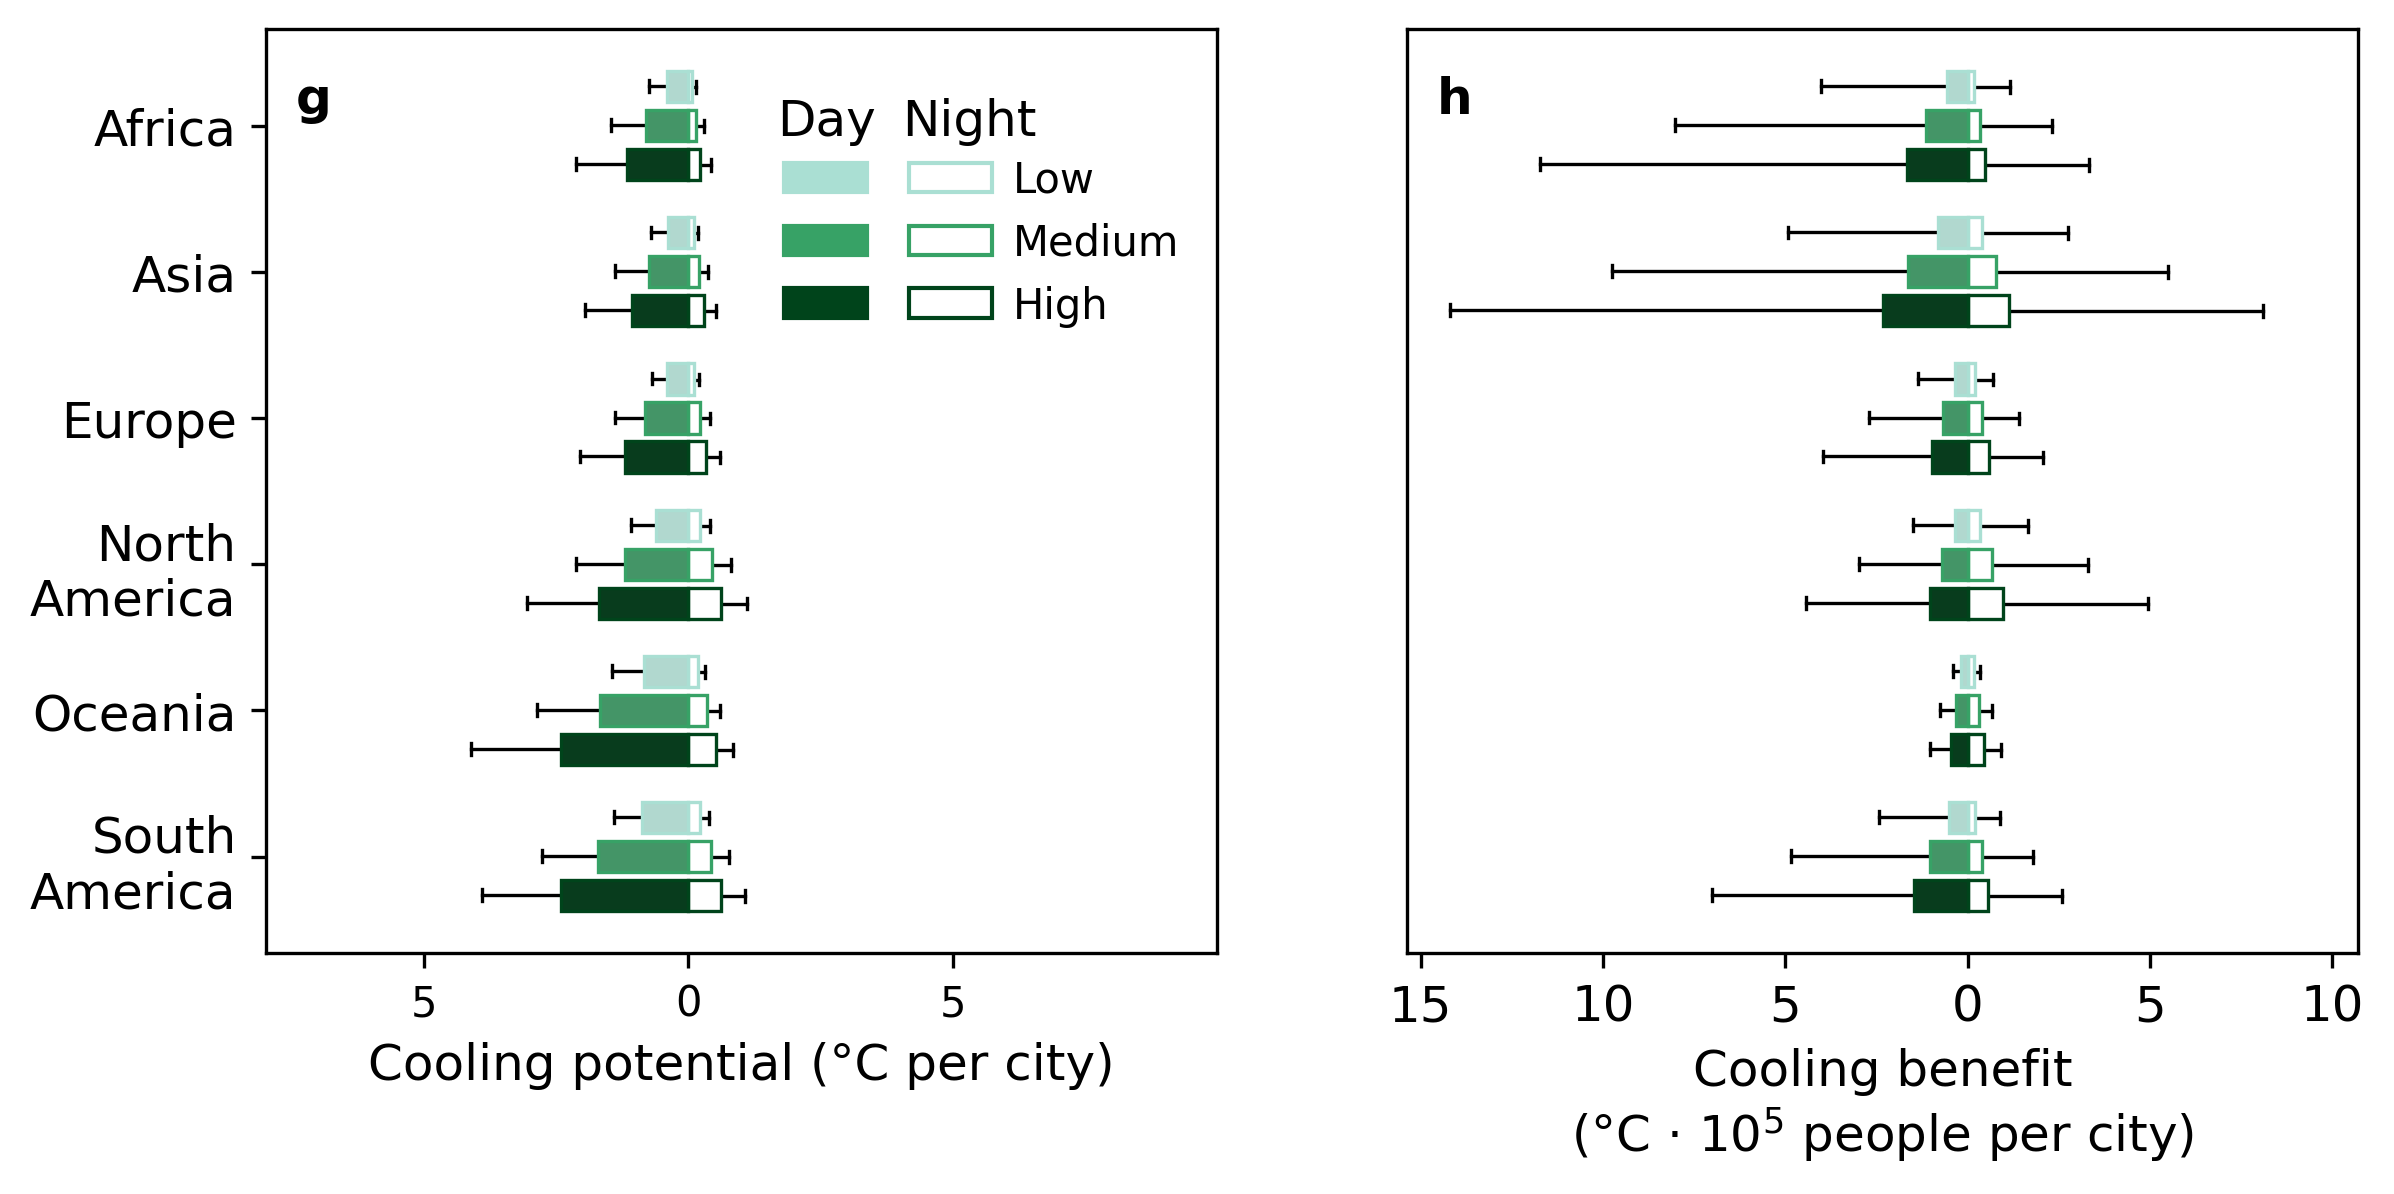

In [107]:
# figure 2 bar plots - 2 cols

edge_colors = plt.get_cmap('BuGn')
edge_colors = edge_colors(np.linspace(0, 1, 4))
edge_colors = [edge_colors[i] for i in [1,2,3]]
white_colors = ['white','white','white']
continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


fig, axs = plt.subplots(1,2,figsize=(9, 4),dpi=300, gridspec_kw={'width_ratios': [1, 1]})

barplot_double_alpha(df_cooling_stat_continent_pop_longer_h[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_night'],
               df_cooling_stat_continent_pop_longer_h[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day'],
               order = continent_order,
                axs=axs[1], y="Continent", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)

barplot_double_alpha(df_cooling_stat_continent_longer_h[df_cooling_stat_continent_longer_h['model'] == 'model4_night'],
               df_cooling_stat_continent_longer_h[df_cooling_stat_continent_longer_h['model'] == 'model4_day'],
               order = continent_order,
                axs=axs[0], y="Continent", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)

for ax in axs.flat:
    ax.legend_.remove() if ax.legend_ else None


axs[1].set_xlabel('Cooling benefit\n(°C · 10${^5}$ people per city)',fontsize=12)
axs[0].set_xlabel('Cooling potential (°C per city)',fontsize=12)

axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[0].set_xticks([])
axs[1].set_xticks([])

axs[1].set_xticks(ticks=[-20,-15,-10,-5,0,5,10,15],labels = [20,15,10,5,0,5,10,15],fontsize=12)
axs[0].set_xticks(ticks=[-5,0,5],labels = [5,0,5])

axs[0].set_yticks([])
axs[1].set_yticks([])
axs[0].set_yticks(ticks=[0,1,2,3,4,5], labels=['Africa', 'Asia', 'Europe', 'North\nAmerica', 'Oceania', 'South\nAmerica'],fontsize=12)

axs[0].set_xlim([-8, 10])

legend_elements = [
    Patch(facecolor=edge_colors[0], edgecolor=edge_colors[0], label=''),
    Patch(facecolor=edge_colors[1], edgecolor=edge_colors[1], label=''),
    Patch(facecolor=edge_colors[2], edgecolor=edge_colors[2], label=''),
    Patch(facecolor='white', edgecolor=edge_colors[0], label='Low'),
    Patch(facecolor='white', edgecolor=edge_colors[1], label='Medium'),
    Patch(facecolor='white', edgecolor=edge_colors[2], label='High'),
]

axs[0].legend(handles=legend_elements, loc='upper right',
           bbox_to_anchor=(1, 0.9), ncol=2, frameon=False,
           handletextpad=0.5, fontsize=10, title_fontsize=10,columnspacing=0.5)

axs[0].text(0.59, 0.9, 'Day', ha='center', va='center', fontsize=12,transform=axs[0].transAxes)
axs[0].text(0.74, 0.9, 'Night', ha='center', va='center', fontsize=12,transform=axs[0].transAxes)
#fig.tight_layout()

#add labels
labels = ['g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')
    
for i, line in enumerate(axs[0].lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    if i<18:
        end_point = (x_data[-1], y_data[-1]-0.03)
        axs[0].plot([end_point[0],0],[end_point[1],end_point[1]],linewidth=0.8,color='black')
        axs[0].plot([end_point[0],end_point[0]],[end_point[1]-0.04,end_point[1]+0.04],linewidth=0.8,color='black')
        
    else:
        start_point = (x_data[0], y_data[0]+0.03)
        axs[0].plot([start_point[0],0],[start_point[1],start_point[1]],linewidth=0.8,color='black')
        axs[0].plot([start_point[0],start_point[0]],[start_point[1]-0.04,start_point[1]+0.04],linewidth=0.8,color='black')
        
for i, line in enumerate(axs[1].lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    if i<18: 
        end_point = (x_data[-1], y_data[-1]-0.03)
        axs[1].plot([end_point[0],0],[end_point[1],end_point[1]],linewidth=0.8,color='black')
        axs[1].plot([end_point[0],end_point[0]],[end_point[1]-0.04,end_point[1]+0.04],linewidth=0.8,color='black')

    else:
        start_point = (x_data[0], y_data[0]+0.03)
        axs[1].plot([start_point[0],0],[start_point[1],start_point[1]],linewidth=0.8,color='black')
        axs[1].plot([start_point[0],start_point[0]],[start_point[1]-0.04,start_point[1]+0.04],linewidth=0.8,color='black')

#save
plt.savefig('./Figs_rev1/fig4.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig4.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [134]:
df_cooling_stat.loc[:,['low_cooling_population_scaled','mid_cooling_population_scaled','hig_cooling_population_scaled']] = df_cooling_stat.loc[
    :,['low_cooling_population','mid_cooling_population','hig_cooling_population']].values*(1e-5)

bins = [-np.inf, -2, -1, -0.5, -0.25, 0]
labels = ['>2.00','1.00~2.00','0.50~1.00','0.25~0.50','0.00~0.25']
df_cooling_stat['low_cooling_pop_class'] = pd.cut(df_cooling_stat['low_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_stat['mid_cooling_pop_class'] = pd.cut(df_cooling_stat['mid_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_stat['hig_cooling_pop_class'] = pd.cut(df_cooling_stat['hig_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_benefits_day = df_cooling_stat.loc[df_cooling_stat['model']=='model4_day',:]
df_cooling_benefits_night = df_cooling_stat.loc[df_cooling_stat['model']=='model4_night',:]
df_cooling_benefits_day_stat = count_cities_in_class(df_cooling_benefits_day,column=['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']).iloc[::-1]
df_cooling_benefits_night_stat = count_cities_in_class(df_cooling_benefits_night,column=['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']).iloc[::-1]

In [90]:
print('---day---')
print(df_cooling_benefits_day_stat)
print(df_cooling_benefits_day_stat/df_cooling_benefits_day_stat['low_cooling_pop_class'].sum())
print('---night---')
print(df_cooling_benefits_night_stat)
print(df_cooling_benefits_night_stat/df_cooling_benefits_night_stat['low_cooling_pop_class'].sum())

---day---
           low_cooling_pop_class  mid_cooling_pop_class  hig_cooling_pop_class
0.00~0.25                   3065                   2791                   2617
0.25~0.50                    253                    282                    308
0.50~1.00                    221                    253                    270
1.00~2.00                    146                    218                    240
>2.00                        228                    369                    478
           low_cooling_pop_class  mid_cooling_pop_class  hig_cooling_pop_class
0.00~0.25               0.783286               0.713263               0.668796
0.25~0.50               0.064656               0.072067               0.078712
0.50~1.00               0.056478               0.064656               0.069001
1.00~2.00               0.037312               0.055712               0.061334
>2.00                   0.058267               0.094301               0.122157
---night---
           low_cooling_pop_cla

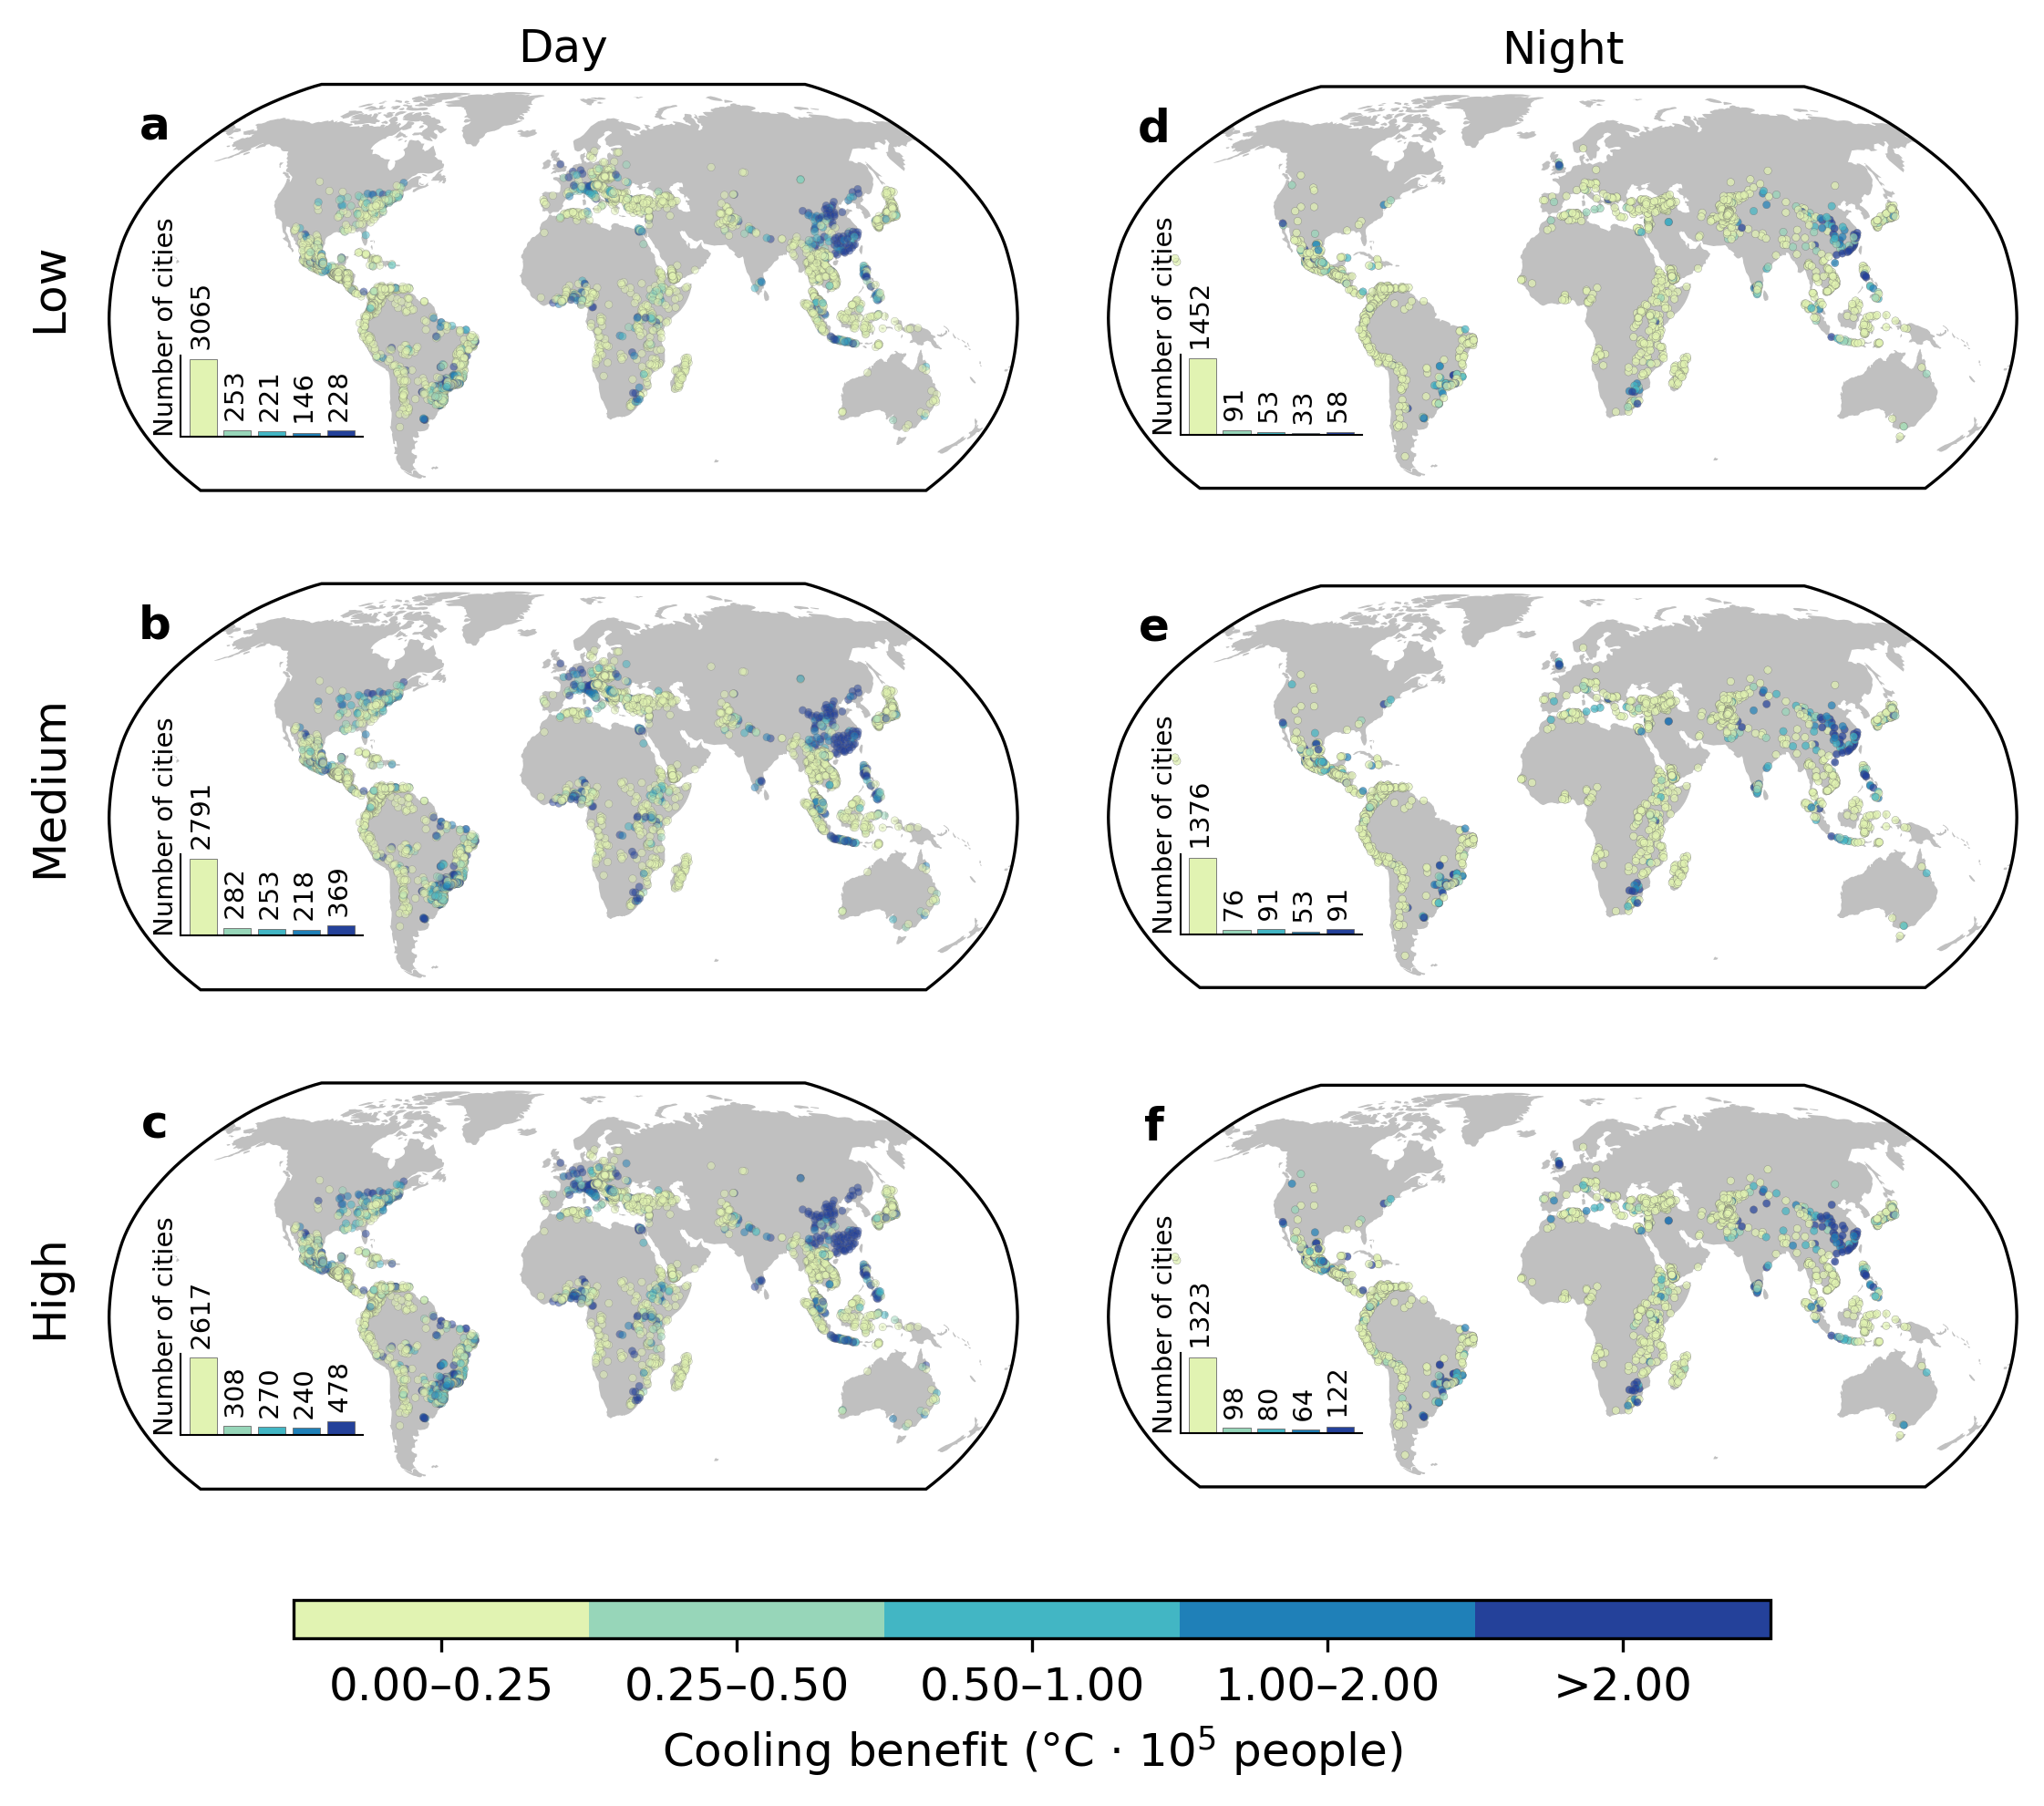

In [135]:
#figure s2 spatial patterns of benefits
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_cooling_benefits_day.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_benefits_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7)
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_cooling_benefits_night.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_benefits_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7)
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=['0.00–0.25', '0.25–0.50','0.50–1.00','1.00–2.00','>2.00'],fontsize=12)
#set title
cbar.set_label('Cooling benefit (°C · 10${^5}$ people)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')


plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig('./Figs_rev1/fig4_benefits.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig4_benefits.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
# figure 4 Influence on diurnal temperature range

In [91]:
df_urban_lst_stat = df_urban_stat.copy()
#cut population to class
bins = [0, 1e3, 1e4, 1e5, np.inf]
labels = ['<1e3','1e3~1e4','1e4~1e5','>1e5']
df_urban_lst_stat['population_class'] = pd.cut(df_urban_lst_stat['population_count'], bins=bins, labels=labels)

df_urban_lst_stat_LST = df_urban_lst_stat[['ADM2_CODE','LST_urban_day_mean','LST_urban_night_mean']].melt(id_vars=['ADM2_CODE'],value_vars=['LST_urban_day_mean','LST_urban_night_mean'],var_name='time',value_name='LST')
df_urban_lst_stat_LST['model'] = df_urban_lst_stat_LST['time'].replace(['LST_urban_day_mean','LST_urban_night_mean'],['model4_day','model4_night'])
df_urban_lst_stat_LST.sort_values(by=['ADM2_CODE','model'],inplace=True)

#filter cities with day and night cooling
df_cooling_count = df_cooling_stat.groupby('ADM2_CODE').count().reset_index()
df_cooling_count_2_code = df_cooling_count.loc[df_cooling_count['model'] == 2,'ADM2_CODE']
df_cooling_day_night = df_cooling_stat[['ADM2_CODE','model','low_cc_cooling','mid_cc_cooling','hig_cc_cooling','geometry','population_count']].loc[df_cooling_stat['ADM2_CODE'].isin(df_cooling_count_2_code)]
df_cooling_day_night = pd.merge(df_cooling_day_night,df_urban_lst_stat_LST[['ADM2_CODE','model','LST']],on=['ADM2_CODE','model'],how='left')
df_cooling_day_night.loc[:,['LST_low','LST_mid','LST_high']] = (np.tile(df_cooling_day_night['LST'].values, (3,1)) + df_cooling_day_night[['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values.T).T

In [92]:
# GET ADM2_CODE AND GEOMETRY
df_dtr = df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['ADM2_CODE','geometry']]
# dd = abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values - df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values)
dd = abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values) - abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values)
df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change']] = dd*(-1)

In [93]:
df_dtr['current_dtr'] = df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day','LST'].values - df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night','LST'].values
df_dtr['low_dtr'] = df_dtr['low_dtr_change'] + df_dtr['current_dtr']
df_dtr['mid_dtr'] = df_dtr['mid_dtr_change'] + df_dtr['current_dtr']
df_dtr['hig_dtr'] = df_dtr['hig_dtr_change'] + df_dtr['current_dtr']

In [94]:
bins = [-np.inf, -1, -0.5, -0.1, 0.1, np.inf]
labels = ['<-1.00','-1.00~-0.50','-0.50~-0.10','-0.10~0.10','>0.10']
df_dtr['low_dtr_change_class'] = pd.cut(df_dtr['low_dtr_change'], bins=bins, labels=labels)
df_dtr['mid_dtr_change_class'] = pd.cut(df_dtr['mid_dtr_change'], bins=bins, labels=labels)
df_dtr['hig_dtr_change_class'] = pd.cut(df_dtr['hig_dtr_change'], bins=bins, labels=labels)

In [95]:
df_dtr = pd.merge(df_dtr,df_urban_lst_stat[['LST_urban_day_mean','LST_urban_night_mean','population_count','population_class','Continent','ADM2_CODE']],on=['ADM2_CODE'],how='left')
df_dtr_stat = count_cities_in_class(df_dtr,column=['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class'])

In [96]:
# count pop in each class
def count_pop_in_class(df, column=['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class']):

    column_value_counts = {}

    for col in column:
        column_value_counts[col] = df.groupby([col])['population_count'].sum().sort_index()

    df_column_value_counts = pd.DataFrame(column_value_counts)
    return df_column_value_counts

In [97]:
df_dtr_stat_pop = count_pop_in_class(df_dtr)*(1e-6) # in millions

C:\Users\admin\AppData\Local\Temp\ipykernel_39896\2550414457.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  column_value_counts[col] = df.groupby([col])['population_count'].sum().sort_index()


In [53]:
df_dtr.describe()

ADM2_CODE  low_dtr_change  mid_dtr_change  hig_dtr_change  \
count     765.000000      765.000000      765.000000      765.000000   
mean    33901.830065       -0.392014       -0.770277       -1.104813   
std     34181.538450        0.468538        0.921624        1.330844   
min       519.000000       -3.524400       -7.048801      -10.383794   
25%     14160.000000       -0.528392       -1.048333       -1.463901   
50%     24059.000000       -0.270022       -0.527930       -0.746860   
75%     35475.000000       -0.071946       -0.143847       -0.208348   
max    191163.000000        0.961768        1.913907        2.582703   

       current_dtr     low_dtr     mid_dtr     hig_dtr  LST_urban_day_mean  \
count   765.000000  765.000000  765.000000  765.000000          765.000000   
mean     16.062234   15.670220   15.291957   14.957420          307.088345   
std       4.193096    4.144314    4.140722    4.165508            4.619058   
min       6.703897    6.371790    6.079384    5.052055          292.831861   
25%      12.804262   12.493976   12.172360   11.958651          304.293674   
50%      15.689311   15.225783   14.706039   14.368678          307.140979   
75%      18.778794   18.272794   17.759489   17.426456          310.278149   
max      31.640690   31.624617   31.608544   31.592471          323.265396   

       LST_urban_night_mean  population_count  
count            765.000000      7.650000e+02  
mean             291.026112      2.081241e+05  
std                4.715988      8.393198e+05  
min              272.346028      0.000000e+00  
25%              288.407284      1.062248e+03  
50%              292.064125      7.259447e+03  
75%              294.639413      6.571565e+04  
max              300.208858      1.468193e+07

In [98]:
df_dtr_stat_continent_long = pd.melt(df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change','Continent']],id_vars=['Continent'],value_vars=['low_dtr_change','mid_dtr_change','hig_dtr_change'],var_name='dtr_change_class',value_name='dtr_change')
df_dtr_stat_pop_long = pd.melt(df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change','population_class']],id_vars=['population_class'],value_vars=['low_dtr_change','mid_dtr_change','hig_dtr_change'],var_name='dtr_change_class',value_name='dtr_change')

In [99]:
df_dtr_stat_pop_long.groupby(['population_class','dtr_change_class']).describe()

C:\Users\admin\AppData\Local\Temp\ipykernel_39896\4145432553.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dtr_stat_pop_long.groupby(['population_class','dtr_change_class']).describe()


dtr_change                                 \
                                       count      mean       std        min   
population_class dtr_change_class                                             
<1e3             hig_dtr_change        186.0 -0.918262  1.116775  -5.771624   
                 low_dtr_change        186.0 -0.325287  0.386685  -1.937081   
                 mid_dtr_change        186.0 -0.640428  0.768096  -3.874163   
1e3~1e4          hig_dtr_change        240.0 -1.071820  1.483605  -7.255630   
                 low_dtr_change        240.0 -0.380450  0.519056  -2.485866   
                 mid_dtr_change        240.0 -0.744638  1.019697  -4.969087   
1e4~1e5          hig_dtr_change        174.0 -1.332504  1.583649 -10.383794   
                 low_dtr_change        174.0 -0.471021  0.559521  -3.524400   
                 mid_dtr_change        174.0 -0.927264  1.099730  -7.048801   
>1e5             hig_dtr_change        164.0 -1.129266  0.945173  -4.141614   
                 low_dtr_change        164.0 -0.402991  0.345075  -1.676016   
                 mid_dtr_change        164.0 -0.792822  0.673277  -3.112038   

                                                                           
                                        25%       50%       75%       max  
population_class dtr_change_class                                          
<1e3             hig_dtr_change   -1.397874 -0.627649 -0.151488  2.582703  
                 low_dtr_change   -0.490339 -0.224674 -0.052802  0.961768  
                 mid_dtr_change   -0.969626 -0.446188 -0.105389  1.913907  
1e3~1e4          hig_dtr_change   -1.305807 -0.539302 -0.138826  0.258077  
                 low_dtr_change   -0.461219 -0.187829 -0.048012  0.099664  
                 mid_dtr_change   -0.920794 -0.375657 -0.095210  0.195244  
1e4~1e5          hig_dtr_change   -1.682876 -0.970594 -0.305394  0.323854  
                 low_dtr_change   -0.607510 -0.332475 -0.108452  0.125342  
                 mid_dtr_change   -1.165241 -0.664040 -0.212845  0.240650  
>1e5             hig_dtr_change   -1.636833 -0.931208 -0.392973  1.216389  
                 low_dtr_change   -0.575277 -0.336442 -0.139705  0.421362  
                 mid_dtr_change   -1.138309 -0.663682 -0.277107  0.839631

0
1


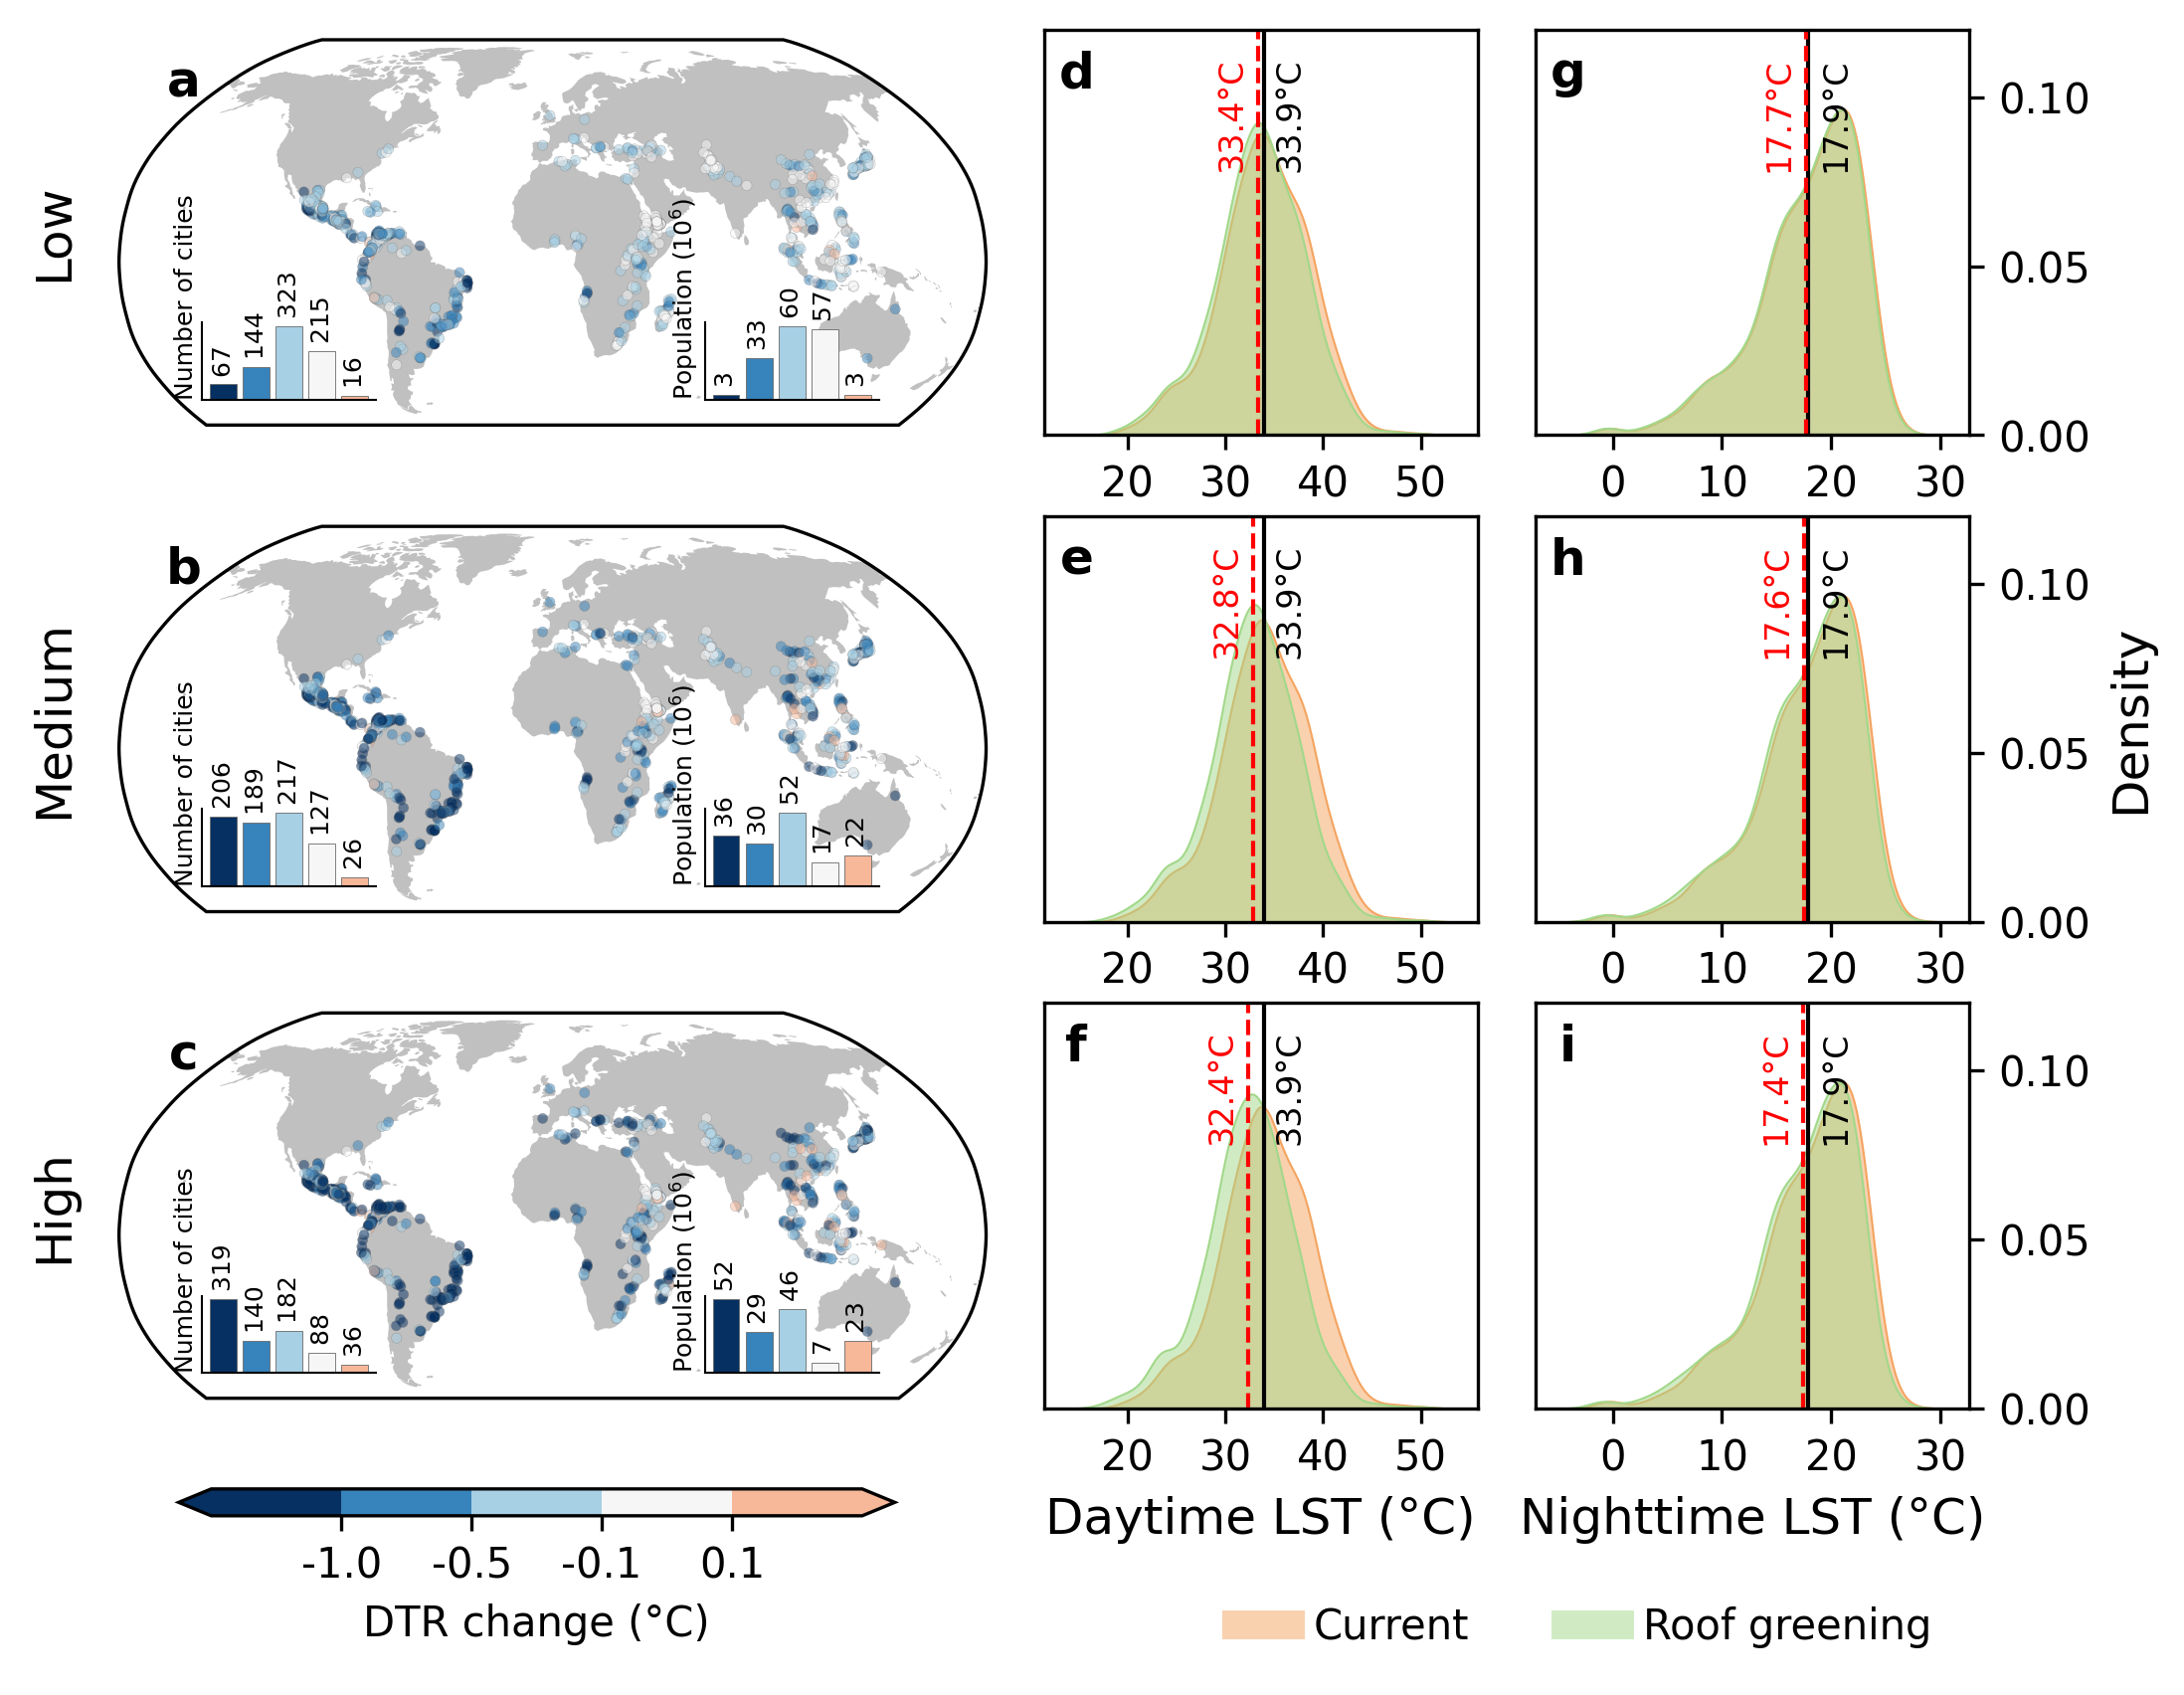

In [63]:
# figure 4 combined 3 col
cmp4 = plt.get_cmap('RdBu_r')
colors4 = cmp4(np.linspace(0, 1, 7))[0:5]
cmp4 = mpl.colors.ListedColormap(colors4)

#plot
fig = plt.figure(figsize=(8,6),dpi=300)

gs = GridSpec(3, 3, figure=fig, width_ratios=[2, 1, 1], height_ratios=[1, 1, 1])

# Define each axis using the GridSpec
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())  # Robinson projection
ax2 = fig.add_subplot(gs[0, 1])  # Regular plot
ax3 = fig.add_subplot(gs[0, 2])  # Regular plot
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())  # Robinson projection
ax5 = fig.add_subplot(gs[1, 1])  # Regular plot
ax6 = fig.add_subplot(gs[1, 2])  # Regular plot
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())  # Robinson projection
ax8 = fig.add_subplot(gs[2, 1])  # Regular plot
ax9 = fig.add_subplot(gs[2, 2])  # Regular plot

axs = np.array([[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]])

#plot cooling effects
plot_columns = ['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_dtr.plot(column=col_name, ax=ax_i, cmap=cmp4, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 6,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax1 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.68,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    inset_ax2 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.1,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax1, df_dtr_stat, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Number of cities',ylabel_loc='bottom',ylabel_pad=1)
    plot_bar_with_labels(inset_ax2, df_dtr_stat_pop, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Population ($10^{6}$)',ylabel_loc='bottom',ylabel_pad=1)
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.yaxis.set_label_position("left")

#y label position at right
axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-1, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp4, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal',shrink=0.6,extend='both')
#set ticks
cbar.set_ticks(ticks=[-0.8, -0.6, -0.4, -0.2],labels=['-1.0','-0.5','-0.1','0.1'],fontsize=10)
#set title
cbar.set_label('DTR change (°C)',fontsize=10)

##
scenario_colors = plt.get_cmap('YlGn')
scenario_colors = scenario_colors(np.linspace(0, 1, 6))
scenario_colors = scenario_colors[2:5]

df_day_night_lst_plot = df_cooling_day_night[['ADM2_CODE','model','LST','LST_low','LST_mid','LST_high']].melt(id_vars=['ADM2_CODE','model'],var_name='Scenarios',value_name='LST_value')
df_day_night_lst_plot['LST_value'] = df_day_night_lst_plot['LST_value']-273.15
df_day_night_dtr_plot = df_dtr[['ADM2_CODE','current_dtr','low_dtr','mid_dtr','hig_dtr']].melt(id_vars=['ADM2_CODE'],var_name='Scenarios',value_name='DTR_value')

scenario_colors2 = np.concatenate((np.array([mcolors.to_rgba('sandybrown')]), scenario_colors))

col_names = ['LST_low','LST_mid','LST_high']
for i in range(0,3):
    axs_i = axs[i,1]
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_day',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[1])

    day_before_lst_mean = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean()
    day_after_lst_mean = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean()
    
    axs_i.axvline(x=day_before_lst_mean,
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=day_after_lst_mean,
                  color='r',linestyle='--',linewidth=1)

    # add text
    axs_i.text(day_before_lst_mean+1, 0.08, f'{day_before_lst_mean:.1f}°C', color='k', fontsize=8, ha='left',rotation=90)
    axs_i.text(day_after_lst_mean-1, 0.08, f'{day_after_lst_mean:.1f}°C', color='r', fontsize=8, ha='right',rotation=90)

    axs_i.set_ylim([0,0.12])
    axs_i.set_yticks([])
    axs_i.set_ylabel('')

    axs_i = axs[i,2]
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_night',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i, color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[1])

    night_before_lst_mean = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean()
    night_after_lst_mean = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean()

    axs_i.axvline(x=night_before_lst_mean,
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=night_after_lst_mean,
                  color='r',linestyle='--',linewidth=1)

    # add text
    axs_i.text(night_before_lst_mean+1, 0.08, f'{night_before_lst_mean:.1f}°C', color='k', fontsize=8, ha='left',rotation=90)
    axs_i.text(night_after_lst_mean-1, 0.08, f'{night_after_lst_mean:.1f}°C', color='r', fontsize=8, ha='right',rotation=90)

    axs_i.set_ylim([0,0.12])
    axs_i.set_yticks([0,0.05,0.10])
    axs_i.yaxis.set_ticks_position('right')
    axs_i.yaxis.set_label_position("right")
    #remove y label
    axs_i.set_ylabel('')

for i in range(0,2):
    #share xy
    print(i)
    axs[i,1].sharex(axs[2,1])
    axs[i,2].sharex(axs[2,2])
    axs[i,1].set_xlabel('')
    axs[i,2].set_xlabel('')
    axs[i,1].set_xticklabels('')
    axs[i,2].set_xticklabels('')

axs[2,1].set_xticks([20,30,40,50],[20,30,40,50])
axs[2,2].set_xticks([0,10,20,30],[0,10,20,30])

axs[1,2].set_ylabel('Density', fontsize=12)
axs[2,1].set_xlabel('Daytime LST (°C)', fontsize=12)
axs[2,2].set_xlabel('Nighttime LST (°C)', fontsize=12)

#legend
legend_elements = [
    Patch(facecolor=scenario_colors2[0], alpha=0.5,label='Current'),
    Patch(facecolor=scenario_colors2[1], alpha=0.5,label='Roof greening'),
]

fig.legend(handles=legend_elements,
           bbox_to_anchor=(0.9, 0.02), ncol=2, frameon=False,
           handletextpad=0.2, fontsize=10, title_fontsize=12,columnspacing=2)

#add labels
labels = ['a', 'b', 'c', 'd','e','f', 'g', 'h', 'i']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.075, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center',zorder=10)

plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.savefig('./Figs_rev1/fig5_combined2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/fig5_combined2.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [64]:
df_day_night_dtr_plot.groupby(['Scenarios']).median()

ADM2_CODE  DTR_value
Scenarios                        
current_dtr    24059.0  15.689311
hig_dtr        24059.0  14.368678
low_dtr        24059.0  15.225783
mid_dtr        24059.0  14.706039

In [65]:
df_dtr_stat_continent_long.groupby(['Continent', 'dtr_change_class']).agg(['mean','std'])

dtr_change          
                                     mean       std
Continent     dtr_change_class                     
Africa        hig_dtr_change    -0.796474  0.803528
              low_dtr_change    -0.277927  0.284068
              mid_dtr_change    -0.550017  0.560053
Asia          hig_dtr_change    -0.562216  0.710485
              low_dtr_change    -0.199990  0.253719
              mid_dtr_change    -0.393253  0.498668
Europe        hig_dtr_change    -0.872202  0.614001
              low_dtr_change    -0.292889  0.205983
              mid_dtr_change    -0.585557  0.411978
North America hig_dtr_change    -1.577879  1.652927
              low_dtr_change    -0.558728  0.556987
              mid_dtr_change    -1.096578  1.115870
Oceania       hig_dtr_change    -2.102917  0.589714
              low_dtr_change    -0.717184  0.206001
              mid_dtr_change    -1.429723  0.405433
South America hig_dtr_change    -1.826489  1.643494
              low_dtr_change    -0.652459  0.590310
              mid_dtr_change    -1.279202  1.148914

C:\Users\admin\AppData\Local\Temp\ipykernel_27740\3304619114.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=df_dtr_stat_continent_long, order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],


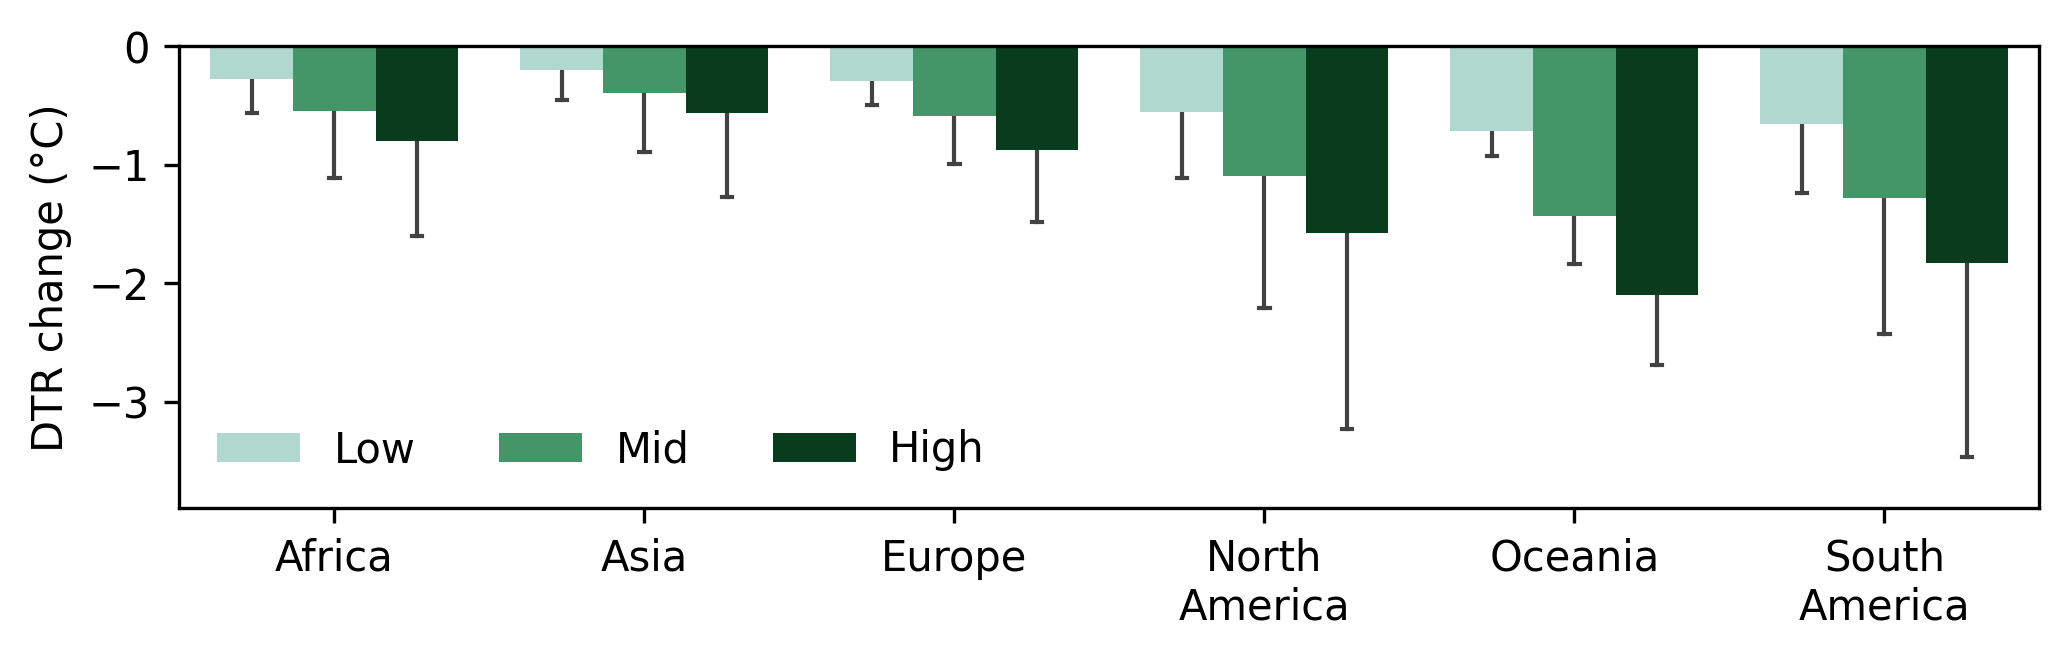

In [66]:
fig,ax = plt.subplots(figsize=(8,2),dpi=300)
sns.barplot(data=df_dtr_stat_continent_long, order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
            x="Continent", y="dtr_change", hue='dtr_change_class',ax=ax,palette=edge_colors,errorbar=('sd'),capsize=.1,errwidth=1,zorder =5)

ax.set_ylabel('DTR change (°C)',fontsize=10)
ax.set_xlabel('')
ax.set_xticks(ticks = range(0,6),labels = ['Africa', 'Asia', 'Europe', 'North\nAmerica', 'Oceania', 'South\nAmerica'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], ['Low', 'Mid', 'High'], loc='lower left', ncol=3, frameon=False)
for spine in ax.spines.values():
    spine.set_zorder(10)

ax.set_ylim(-3.9,0)

plt.savefig('./Figs_rev1/figs2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/figs2.pdf', dpi=300, bbox_inches='tight')

In [100]:
# figure 5 cases of megacities
df_cooling_stat_day_night = df_cooling_stat.loc[df_cooling_stat['ADM2_CODE'].isin(df_cooling_count_2_code)].sort_values(by='population_count',ascending=False)

In [101]:
df_cooling_stat_day_night = df_urban_stat[['ADM2_CODE','ADM2_NAME']].merge(df_cooling_stat_day_night, on='ADM2_CODE', how='right')

In [ ]:
df_cooling_day_night_largecities = df_cooling_stat_day_night.loc[df_cooling_stat_day_night['ADM2_CODE'].isin([13215,51360,29874])]
df_dtr_largecities = df_dtr.loc[df_dtr['ADM2_CODE'].isin([13215,51360,29874])]

'''
XI'AN 13215 CN
Kenya Nairobi Nairobi 51360 AF
Baltimore 29874 US
'''

"\nXI'AN 13215 CN\nKenya Nairobi Nairobi 51360 AF\n--South Yorkshire 40130 EN\nBaltimore 29874 US\n"

In [104]:
df_dtr_largecities

ADM2_CODE                    geometry  low_dtr_change  mid_dtr_change  \
149    13215.0  POINT (108.79514 34.10509)       -0.048287       -0.096277   
459    29874.0  POINT (-76.64048 39.44744)       -0.114909       -0.229522   
652    51360.0   POINT (36.86835 -1.28995)       -0.905557       -1.800538   

     hig_dtr_change  current_dtr    low_dtr    mid_dtr    hig_dtr  \
149       -0.141514    16.466970  16.418683  16.370693  16.325457   
459       -0.340598    15.400281  15.285372  15.170758  15.059682   
652       -2.617502    21.169604  20.264047  19.369066  18.552102   

    low_dtr_change_class mid_dtr_change_class hig_dtr_change_class  \
149           -0.10~0.10           -0.10~0.10          -0.50~-0.10   
459          -0.50~-0.10          -0.50~-0.10          -0.50~-0.10   
652          -1.00~-0.50               <-1.00               <-1.00   

     LST_urban_day_mean  LST_urban_night_mean  population_count  \
149          311.854214            295.387244       7337573.731   
459          308.428183            293.027902       1517199.675   
652          308.927803            287.758199       4473005.085   

    population_class      Continent  
149             >1e5           Asia  
459             >1e5  North America  
652             >1e5         Africa

In [105]:
df_cooling_day_night_largecities_h = df_cooling_day_night_largecities[['ADM2_CODE','model','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','model'],var_name='cooling_type',value_name='effects')
df_cooling_day_night_largecities_h2 = df_cooling_day_night_largecities[['ADM2_CODE','model','uncertainty_ratio']]
df_cooling_day_night_largecities_h = pd.merge(df_cooling_day_night_largecities_h,df_cooling_day_night_largecities_h2,on=['ADM2_CODE','model'])
df_cooling_day_night_largecities_h['uncertainty'] = df_cooling_day_night_largecities_h['effects'] * df_cooling_day_night_largecities_h['uncertainty_ratio']

In [106]:
df_cooling_day_night_largecities_h.sort_values(by=['ADM2_CODE','model','cooling_type'])

ADM2_CODE         model    cooling_type   effects  uncertainty_ratio  \
12      13215    model4_day  hig_cc_cooling -0.528994           0.125805   
0       13215    model4_day  low_cc_cooling -0.180502           0.125805   
6       13215    model4_day  mid_cc_cooling -0.359894           0.125805   
13      13215  model4_night  hig_cc_cooling -0.387480           0.118451   
1       13215  model4_night  low_cc_cooling -0.132215           0.118451   
7       13215  model4_night  mid_cc_cooling -0.263617           0.118451   
16      29874    model4_day  hig_cc_cooling -0.573030           0.128023   
4       29874    model4_day  low_cc_cooling -0.193325           0.128023   
10      29874    model4_day  mid_cc_cooling -0.386153           0.128023   
17      29874  model4_night  hig_cc_cooling -0.232432           0.153577   
5       29874  model4_night  low_cc_cooling -0.078416           0.153577   
11      29874  model4_night  mid_cc_cooling -0.156631           0.153577   
15      51360    model4_day  hig_cc_cooling -3.494717           0.074334   
3       51360    model4_day  low_cc_cooling -1.209040           0.074334   
9       51360    model4_day  mid_cc_cooling -2.403960           0.074334   
14      51360  model4_night  hig_cc_cooling -0.877214           0.120375   
2       51360  model4_night  low_cc_cooling -0.303483           0.120375   
8       51360  model4_night  mid_cc_cooling -0.603422           0.120375   

    uncertainty  
12    -0.066550  
0     -0.022708  
6     -0.045276  
13    -0.045898  
1     -0.015661  
7     -0.031226  
16    -0.073361  
4     -0.024750  
10    -0.049436  
17    -0.035696  
5     -0.012043  
11    -0.024055  
15    -0.259776  
3     -0.089873  
9     -0.178696  
14    -0.105595  
2     -0.036532  
8     -0.072637

In [146]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',['effects','uncertainty']] = df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',['effects','uncertainty']]*-1

In [102]:
# df_cooling_day_night_largecities_h['lower'] = df_cooling_day_night_largecities_h['effects'] + df_cooling_day_night_largecities_h['uncertainty']
# df_cooling_day_night_largecities_h['upper'] = df_cooling_day_night_largecities_h['effects'] - df_cooling_day_night_largecities_h['uncertainty']

In [147]:
df_cooling_day_night_largecities_h = df_cooling_day_night_largecities_h.sort_values(by=['ADM2_CODE','model'])

In [148]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_day',:].sort_values(by=['cooling_type','effects'])

ADM2_CODE       model    cooling_type   effects  uncertainty_ratio  \
15      51360  model4_day  hig_cc_cooling -3.494717           0.074334   
16      29874  model4_day  hig_cc_cooling -0.573030           0.128023   
12      13215  model4_day  hig_cc_cooling -0.528994           0.125805   
3       51360  model4_day  low_cc_cooling -1.209040           0.074334   
4       29874  model4_day  low_cc_cooling -0.193325           0.128023   
0       13215  model4_day  low_cc_cooling -0.180502           0.125805   
9       51360  model4_day  mid_cc_cooling -2.403960           0.074334   
10      29874  model4_day  mid_cc_cooling -0.386153           0.128023   
6       13215  model4_day  mid_cc_cooling -0.359894           0.125805   

    uncertainty  
15    -0.259776  
16    -0.073361  
12    -0.066550  
3     -0.089873  
4     -0.024750  
0     -0.022708  
9     -0.178696  
10    -0.049436  
6     -0.045276

In [149]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',:].sort_values(by=['cooling_type','effects'])

ADM2_CODE         model    cooling_type   effects  uncertainty_ratio  \
17      29874  model4_night  hig_cc_cooling  0.232432           0.153577   
13      13215  model4_night  hig_cc_cooling  0.387480           0.118451   
14      51360  model4_night  hig_cc_cooling  0.877214           0.120375   
5       29874  model4_night  low_cc_cooling  0.078416           0.153577   
1       13215  model4_night  low_cc_cooling  0.132215           0.118451   
2       51360  model4_night  low_cc_cooling  0.303483           0.120375   
11      29874  model4_night  mid_cc_cooling  0.156631           0.153577   
7       13215  model4_night  mid_cc_cooling  0.263617           0.118451   
8       51360  model4_night  mid_cc_cooling  0.603422           0.120375   

    uncertainty  
17     0.035696  
13     0.045898  
14     0.105595  
5      0.012043  
1      0.015661  
2      0.036532  
11     0.024055  
7      0.031226  
8      0.072637

In [150]:
df_cooling_day_night_largecities_h

ADM2_CODE         model    cooling_type   effects  uncertainty_ratio  \
0       13215    model4_day  low_cc_cooling -0.180502           0.125805   
6       13215    model4_day  mid_cc_cooling -0.359894           0.125805   
12      13215    model4_day  hig_cc_cooling -0.528994           0.125805   
1       13215  model4_night  low_cc_cooling  0.132215           0.118451   
7       13215  model4_night  mid_cc_cooling  0.263617           0.118451   
13      13215  model4_night  hig_cc_cooling  0.387480           0.118451   
4       29874    model4_day  low_cc_cooling -0.193325           0.128023   
10      29874    model4_day  mid_cc_cooling -0.386153           0.128023   
16      29874    model4_day  hig_cc_cooling -0.573030           0.128023   
5       29874  model4_night  low_cc_cooling  0.078416           0.153577   
11      29874  model4_night  mid_cc_cooling  0.156631           0.153577   
17      29874  model4_night  hig_cc_cooling  0.232432           0.153577   
3       51360    model4_day  low_cc_cooling -1.209040           0.074334   
9       51360    model4_day  mid_cc_cooling -2.403960           0.074334   
15      51360    model4_day  hig_cc_cooling -3.494717           0.074334   
2       51360  model4_night  low_cc_cooling  0.303483           0.120375   
8       51360  model4_night  mid_cc_cooling  0.603422           0.120375   
14      51360  model4_night  hig_cc_cooling  0.877214           0.120375   

    uncertainty  
0     -0.022708  
6     -0.045276  
12    -0.066550  
1      0.015661  
7      0.031226  
13     0.045898  
4     -0.024750  
10    -0.049436  
16    -0.073361  
5      0.012043  
11     0.024055  
17     0.035696  
3     -0.089873  
9     -0.178696  
15    -0.259776  
2      0.036532  
8      0.072637  
14     0.105595

In [151]:
df_dtr_largecities_h = df_dtr_largecities[['ADM2_CODE','low_dtr_change','mid_dtr_change','hig_dtr_change']].melt(id_vars=['ADM2_CODE'],var_name='cooling_type',value_name='effects')

In [152]:
df_dtr_largecities_h.sort_values(by=['effects'])

ADM2_CODE    cooling_type   effects
8    51360.0  hig_dtr_change -2.617502
5    51360.0  mid_dtr_change -1.800538
2    51360.0  low_dtr_change -0.905557
7    29874.0  hig_dtr_change -0.340598
4    29874.0  mid_dtr_change -0.229522
6    13215.0  hig_dtr_change -0.141514
1    29874.0  low_dtr_change -0.114909
3    13215.0  mid_dtr_change -0.096277
0    13215.0  low_dtr_change -0.048287

0 13215
<Axes.ArtistList of 3 patches>
1 29874
<Axes.ArtistList of 3 patches>
2 51360
<Axes.ArtistList of 3 patches>


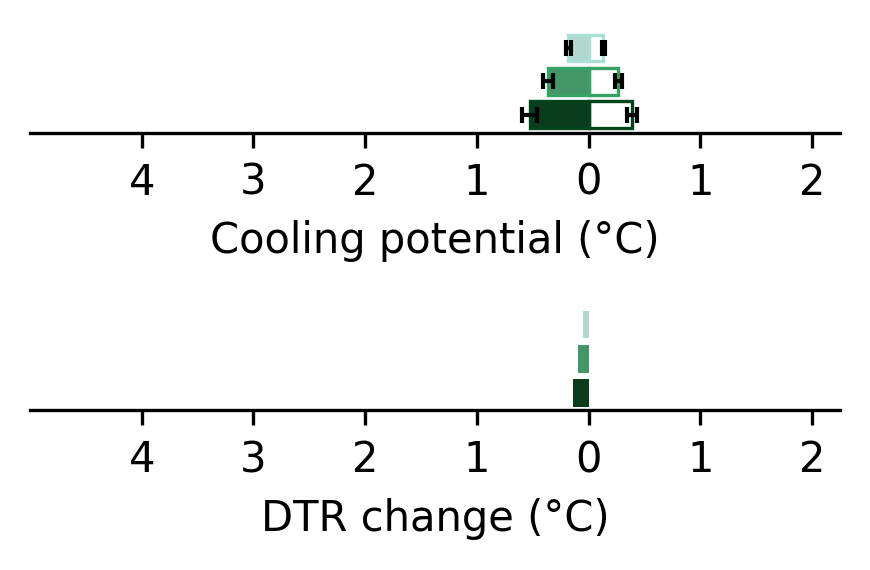

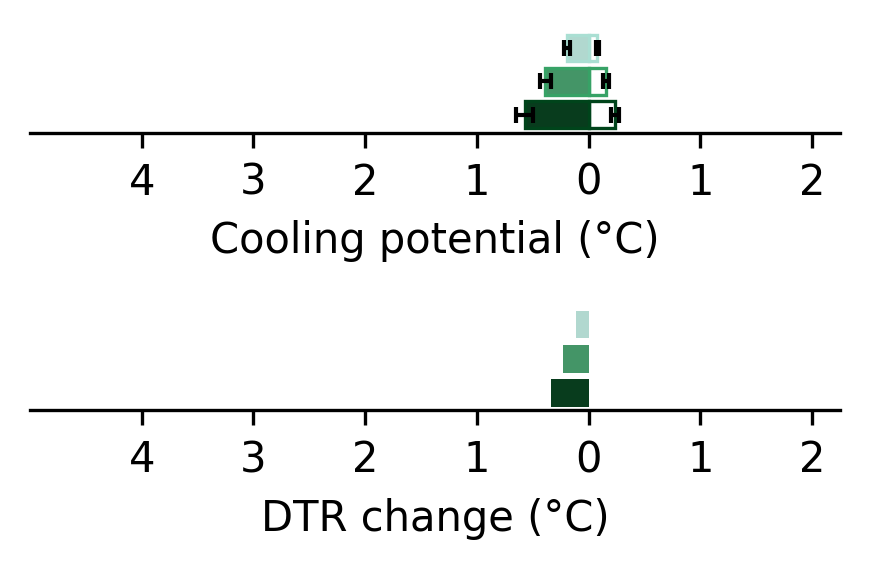

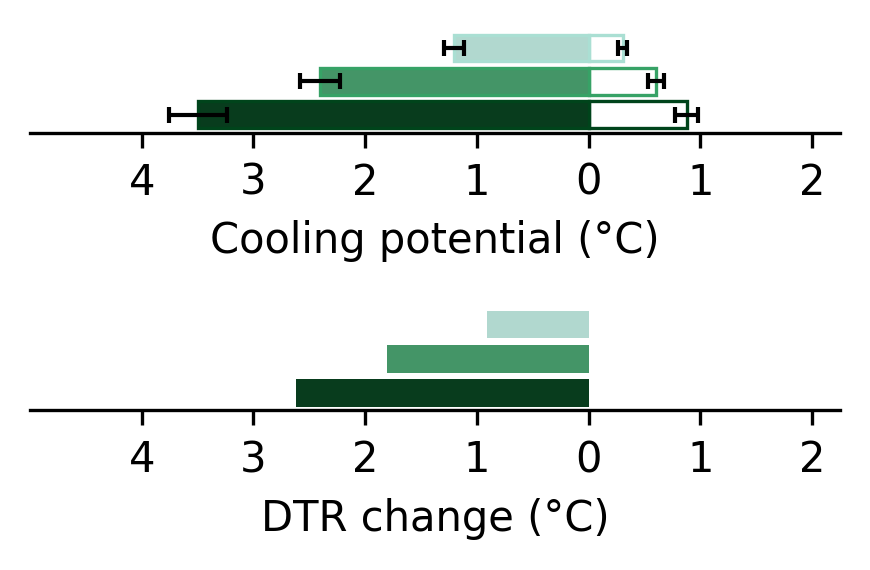

In [154]:
#figures for each city -1 cooling potential

for i, city in enumerate(df_cooling_day_night_largecities_h['ADM2_CODE'].unique()):
    print(i,city)
    df_cooling_stat_day_night_city = df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['ADM2_CODE']==city]
    df_dtr_largecities_city = df_dtr_largecities_h.loc[df_dtr_largecities_h['ADM2_CODE']==city]

    fig = plt.figure(figsize=(3, 2),dpi=300)
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    barplot_double_city(df_cooling_stat_day_night_city[df_cooling_stat_day_night_city['model'] == 'model4_night'],
               df_cooling_stat_day_night_city[df_cooling_stat_day_night_city['model'] == 'model4_day'],
               order = ['low_cc_cooling','mid_cc_cooling','hig_cc_cooling'],
                axs=ax, y="cooling_type", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)
    #ax.vlines(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],color='white',linewidth=1.5)
    df_cooling_stat_day_night_city_resort = df_cooling_stat_day_night_city.iloc[[3,4,5,0,1,2],:]
    x_pos_list = []
    y_pos_list = []

    for i, bar in enumerate(ax.patches):
        x_pos = bar.get_x() + bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2

        if not np.isnan(x_pos):
            x_pos_list.append(x_pos)
            y_pos_list.append(y_pos)

    ax.errorbar(x_pos_list, y_pos_list, xerr=abs(df_cooling_stat_day_night_city_resort.loc[:,'uncertainty']), fmt='none', c='black', capsize=2, elinewidth=1, zorder=10)
        
    ax.legend_.remove() if ax.legend_ else None
    ax.set_xlabel('Cooling potential (°C)')
    ax.set_ylabel('')
    ax.set_xticks([-4, -3, -2, -1, 0, 1, 2],[4,3,2,1,0,1,2])
    ax.set_yticks([])
    ax.set_xlim([-5,2.25])
    #remove axis right and top
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #ax2
    sns.barplot(data=df_dtr_largecities_city, order = ['low_dtr_change','mid_dtr_change','hig_dtr_change'],
                y="cooling_type", x="effects", hue='cooling_type',ax=ax2,palette=edge_colors,errorbar=None,orient = 'h',linewidth=0.8)
    ax2.set_xlabel('DTR change (°C)')
    ax2.set_ylabel('')
    ax2.set_xticks([-4, -3, -2, -1, 0, 1, 2],[4,3,2,1,0,1,2])
    ax2.set_yticks([])
    ax2.set_xlim([-5,2.25])
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    if city == 13255:
        for i, bar in enumerate(ax2.patches):
            x_pos = bar.get_x() + bar.get_width()
            y_pos = bar.get_y() + bar.get_height() / 2
            #add value
            print(x_pos,y_pos)
            ax2.text(x_pos*(-1), y_pos, str(round(bar.get_width(),3)), ha='right', va='center',fontsize=8)

    plt.tight_layout()
    plt.savefig('./Figs_rev1/'+str(city)+'_cooling_potential.png',bbox_inches='tight',dpi=300,transparent=True)


In [110]:
# figrue s5 
df_all_model_compare = pd.read_csv('./all_model_results/result_all_allpixel_watermask0_vif.csv')
df_all_model_compare = df_all_model_compare.loc[df_all_model_compare['metrics'] == 'r2',:]
shp_city = gpd.read_file('../../cities/Global_Cities3.shp')
shp_city_point = shp_city[['ADM2_CODE','geometry']]
shp_city_point['geometry'] = shp_city_point['geometry'].centroid
# merge geo
df_all_model_compare = pd.merge(df_all_model_compare,shp_city_point,how='left',left_on='ADM2CODE',right_on='ADM2_CODE')
df_all_model_compare = gpd.GeoDataFrame(df_all_model_compare,geometry='geometry')

C:\Users\admin\AppData\Local\Temp\ipykernel_27740\343892451.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_city_point['geometry'] = shp_city_point['geometry'].centroid
c:\Users\admin\.conda\envs\nicenv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


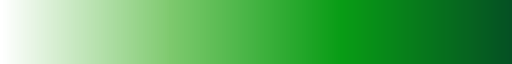

In [111]:
cmp3 = cmaps.WhiteGreen
cmp3

model4_day
model3_day
model5_day
model2_day
model4_night
model3_night
model5_night
model2_night


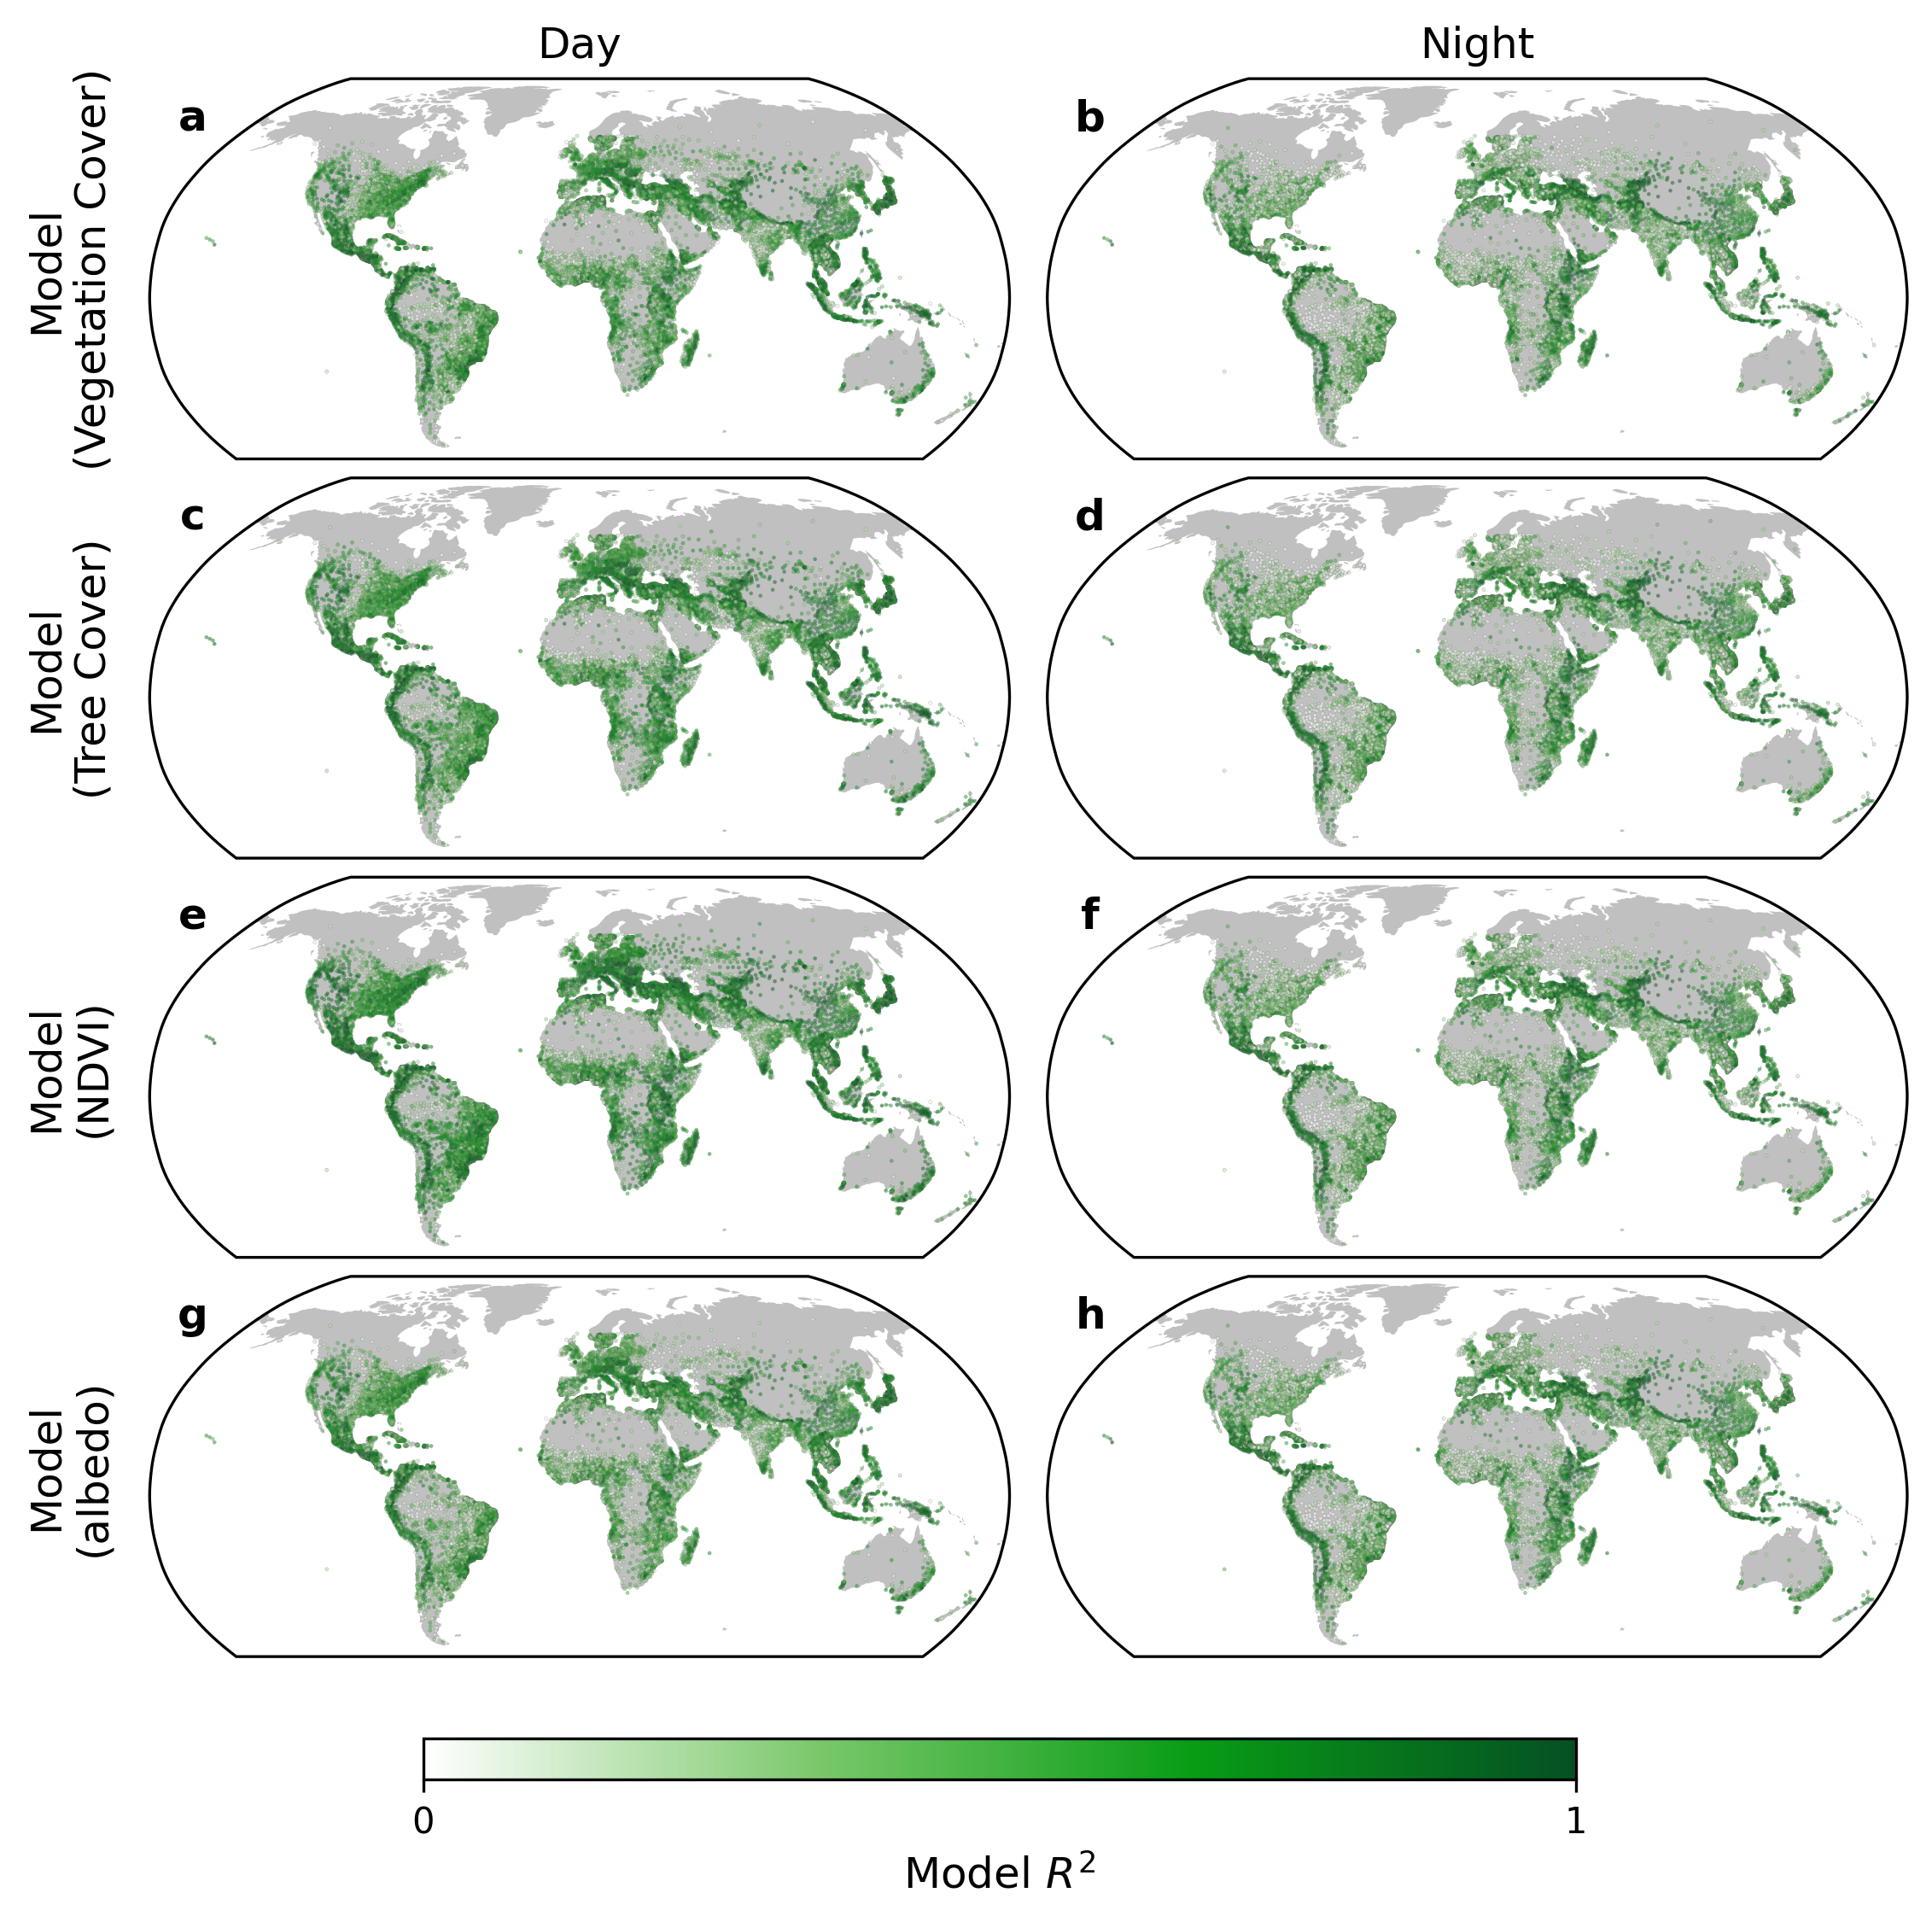

In [112]:
# figrue s5 model r2
#plot
fig,axs = plt.subplots(4,2,figsize=(9,8),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['model4_day', 'model3_day', 'model5_day','model2_day',
                'model4_night', 'model3_night','model5_night', 'model2_night']

for i in range(4):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    print(col_name)
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    df_all_model_compare.plot(column=col_name, ax=ax_i, cmap=cmp3, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 1,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(4):
    ax_i = axs[i,1]
    col_name = plot_columns[i+4]
    print(col_name)
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    df_all_model_compare.plot(column=col_name, ax=ax_i, cmap=cmp3, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 1,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Model\n(Vegetation Cover)',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Model\n(Tree Cover)',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('Model\n(NDVI)',fontsize=12,rotation=90,labelpad=10)
axs[3,0].set_ylabel('Model\n(albedo)',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=0, 
                            vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmp3, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[0,1])
#set title
cbar.set_label('Model ${R^2}$',fontsize=12)

#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')


plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.savefig('./Figs_rev1/figs5.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs_rev1/figs5.pdf', dpi=300, bbox_inches='tight')
# plt.close()